In [15]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde, ks_2samp, zscore, stats
import matplotlib.path as mpath
from scipy.stats import gaussian_kde, iqr
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import sys
import platform

def load_clinical_manifest(directory):
    """
    Load the clinical manifest from a specified directory.

    Inputs:
    - directory (str): The directory path where the file is located.

    Outputs:
    - clinical_manifest (DataFrame): A DataFrame containing the clinical manifest data.
    """
    filepath = os.path.join(directory, 'clinical_gdc_manifest.txt')
    clinical_manifest = pd.read_csv(filepath, sep='\t')
    print('Clinical manifest shape:', clinical_manifest.shape)
    return clinical_manifest

def analyze_filenames(manifest_df, directory_path):
    """
    Analyze the uniqueness and overlap of filenames between a manifest and a directory.

    Inputs:
    - manifest_df (DataFrame): Manifest containing filenames.
    - directory_path (str): Directory path containing files to compare.

    Outputs:
    - dict: Summary of percentages including unique filenames, overlap, and non-overlap.
    """
    total_filenames = len(manifest_df['filename'])
    unique_filenames = len(manifest_df['filename'].unique())
    percent_unique = (unique_filenames / total_filenames) * 100

    directory_files = set(os.listdir(directory_path))
    manifest_files = set(manifest_df['filename'])

    overlap_files = manifest_files.intersection(directory_files)
    percent_overlap = (len(overlap_files) / total_filenames) * 100
    non_overlap_files = manifest_files.difference(directory_files)
    percent_non_overlap = (len(non_overlap_files) / total_filenames) * 100

    return {
        "percent_unique_filenames_in_manifest": percent_unique,
        "percent_overlap_with_directory": percent_overlap,
        "percent_non_overlap_with_directory": percent_non_overlap
    }

def load_dataframes(exps_filename, key_filename):
    """
    Load gene expression and key DataFrames from files.

    Inputs:
    - exps_filename (str): Path to gene expression file.
    - key_filename (str): Path to gene key file.

    Outputs:
    - gene_exps (DataFrame): Loaded gene expression data.
    - gene_key (DataFrame): Loaded gene key data.
    """
    gene_exps = pd.read_csv(exps_filename, index_col=0)
    gene_key = pd.read_csv(key_filename, index_col=0)
    return gene_exps, gene_key

def normalize_gene_expressions(df):
    """
    Z-score normalize each gene expression in the dataset.

    Parameters:
    - df: DataFrame with gene expression data where rows are samples and columns are genes.

    Returns:
    - Normalized DataFrame with the same shape as input.
    """
    # Apply z-score normalization to each gene (column) in the DataFrame
    normalized_df = df.apply(zscore, axis=1)
    # normalized_df = df.apply(zscore, axis=0)

    return normalized_df

def normalize_gene_expressions(df):
    """
    Normalize gene expressions using Z-score normalization.

    Inputs:
    - df (DataFrame): DataFrame with gene expression data.

    Outputs:
    - normalized_df (DataFrame): Normalized DataFrame with the same shape as input.
    """
    return df.apply(zscore, axis=1)

def classify_cancer_type(row):
    """
    Classifies the given row value into a cancer type or category.

    Parameters:
    - row: String, the diagnosis or condition to classify.

    Returns:
    - A string representing the cancer type or category:
        - 'Leukemia', 'Lymphoma', 'Myeloma', 'Other_Cancer', 'Unknown', or 'Other'.
    """

    # List of diagnoses classified as leukemia types
    leukemia_types = [
        "Acute myeloid leukemia, NOS",
        "Common precursor B ALL",
        "Acute lymphocytic leukemia",
        "Acute myeloid leukemia with mutated NPM1",
        "Acute lymphoblastic leukemia, NOS",
        "Acute myeloid leukemia with myelodysplasia-related changes",
        "Leukemia, NOS",
        "Acute myeloid leukemia, CBF-beta/MYH11",
        "Acute myeloid leukemia with mutated CEBPA",
        "Acute myelomonocytic leukemia",
        "Acute promyelocytic leukaemia, PML-RAR-alpha",
        "Atypical chronic myeloid leukemia, BCR/ABL negative",
        "Acute monoblastic and monocytic leukemia",
        "Chronic neutrophilic leukemia",
        "Acute myeloid leukemia with t(8;21)(q22;q22); RUNX1-RUNX1T1",
        "Acute myeloid leukemia with t(9;11)(p22;q23); MLLT3-MLL",
        "Acute myeloid leukemia with inv(3)(q21q26.2) or t(3;3)(q21;q26.2); RPN1-EVI1",
        "Acute leukemia, NOS",
        "Acute myeloid leukemia, minimal differentiation",
        "Precursor B-cell lymphoblastic leukemia",
        "Precursor cell lymphoblastic leukemia, not phenotyped",
        "Precursor cell lymphoblastic leukemia, NOS",
        "Chronic myelomonocytic leukemia, NOS",
        "Acute myeloid leukemia with t(6;9)(p23;q34); DEK-NUP214",
        "Mixed phenotype acute leukemia, T/myeloid, NOS",
        "Acute erythroid leukaemia",
        "Refractory anemia with excess blasts",
        "Subacute lymphoid leukemia",
        "Essential thrombocythemia",
        "Mixed phenotype acute leukemia, B/myeloid, NOS",
        "Acute megakaryoblastic leukaemia",
        "Undifferentiated leukaemia",
        "Lymphoid leukemia, NOS",
        "Myeloid leukemia associated with Down Syndrome",
        "Chronic lymphocytic leukemia"
    ]
    
    # List of diagnoses classified as lymphoma types
    lymphoma_types = [
        "Burkitt lymphoma, NOS (Includes all variants)",
        "Diffuse large B-cell lymphoma, NOS",
        "Burkitt-like lymphoma",
        "B cell lymphoma, NOS",
        "EBV positive diffuse large B-cell lymphoma of the elderly",
        "Primary diffuse large B-cell lymphoma of the CNS",
        "B-cell lymphoma, unclassifiable, with features intermediate between diffuse large B-cell lymphoma and Burkitt lymphoma"
    ]
    
    # List of diagnoses classified as myeloma types
    myeloma_types = [
        "Multiple myeloma",
        "Plasma cell myeloma"
    ]
    
    # List of diagnoses classified as other types of cancer
    other_types = [
        "Therapy related myeloid neoplasm",
        "Myelodysplastic/myeloproliferative neoplasm, unclassifiable",
        "Myloproliferative neoplasm, unclassifiable",
        "Myeloid sarcoma",
        "Myelodysplastic syndrome, unclassifiable",
        "Refractory cytopenia with multilineage dysplasia",
        "Neuroblastoma, NOS",
        "Osteosarcoma, NOS",
        "Neoplasm, uncertain whether benign or malignant",
        "Blastic plasmacytoid dendritic cell neoplasm",
        "Tumor, NOS"
    ]
    
    # List of unknown or unreported diagnoses
    unknown_types = [
        "Not Reported",
        "Unknown"
    ]
    
    # Determine the cancer type based on the provided diagnosis
    if row in leukemia_types:
        return 'Leukemia'
    elif row in lymphoma_types:
        return 'Lymphoma'
    elif row in myeloma_types:
        return 'Myeloma'
    elif row in other_types:
        return 'Other_Cancer'
    elif row in unknown_types:
        return 'Unknown'
    else:
        # Default category for cases not matching any specific list
        return 'Other'


def clean_and_classify_dataframe(df, classify_by):
    """
    Clean and classify a clinical manifest DataFrame by removing unnecessary columns, marking healthy samples,
    and adding a classification column based on either cancer type or cancer stage.

    Inputs:
    - df (DataFrame): The clinical manifest DataFrame to be cleaned and classified.
    - classify_by (str): The classification criterion ('cancer_type' or 'cancer_stage').

    Outputs:
    - df_copy (DataFrame): A cleaned and classified DataFrame.

    Function details:
    - Filters and modifies specific columns to mark healthy samples as 'Healthy'.
    - Adds a new column ('cancer_type' or 'cancer_stage') based on the classify_by parameter.
    """
    # Create a copy of the input DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Define the sample types considered healthy
    healthy_sample_types = ['Blood Derived Normal', 'Bone Marrow Normal', 'Control Analyte', 'Solid Tissue Normal']

    # Define columns that may be updated to 'Healthy' based on conditions
    health_info_columns = [
        "ajcc_pathologic_stage", "tumor_grade", "ajcc_pathologic_t", "ajcc_pathologic_m",
        "ajcc_pathologic_n", "figo_stage", "wilms_tumor_histologic_subtype", 'diagnosis_iss_stage',
        'diagnosis_ann_arbor_pathologic_stage', 'diagnosis_ajcc_pathologic_stage'
    ]

    # Iterate over each column in the DataFrame to clean or update based on conditions
    for column in df_copy.columns:
        unique_values = df_copy[column].dropna().unique()

        # Drop columns that are entirely NaN or contain only uninformative values like 'Not Reported'
        if len(unique_values) == 0 or (len(unique_values) == 1 and unique_values[0] in ['Not Reported', 'not reported', 'None']):
            df_copy.drop(column, axis=1, inplace=True)
        else:
            # Update specific columns to mark healthy samples as 'Healthy'
            if column in health_info_columns:
                condition = (
                    df_copy['sample_type'].isin(healthy_sample_types) & 
                    df_copy[column].notna() & 
                    df_copy[column].astype(str).str.strip().ne('')  # Ensure non-empty string values
                )
                df_copy.loc[condition, column] = 'Healthy'

    # Add a new column for classification based on the classify_by parameter
    if classify_by == 'cancer_type':
        # Add the 'cancer_type' column if the relevant diagnosis column exists
        if 'diagnosis_primary_diagnosis' in df_copy.columns:
            df_copy['cancer_type'] = df_copy['diagnosis_primary_diagnosis'].apply(classify_cancer_type)
            # Update 'cancer_type' to 'Healthy' for healthy sample types
            df_copy.loc[df_copy['sample_type'].isin(healthy_sample_types), 'cancer_type'] = 'Healthy'
        else:
            # If the diagnosis column is missing, default to 'Unknown'
            df_copy['cancer_type'] = 'Unknown'
    elif classify_by == 'cancer_stage':
        # Add the 'cancer_stage' column if the relevant stage column exists
        if 'diagnosis_ajcc_pathologic_stage' in df_copy.columns:
            df_copy['cancer_stage'] = df_copy['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)
        else:
            # If the stage column is missing, default to 'Unknown'
            df_copy['cancer_stage'] = 'Unknown'
    
    # Print the shape of the cleaned DataFrame for verification
    print('Cleaned clinical manifest shape:', df_copy.shape)
    
    # Return the cleaned and classified DataFrame
    return df_copy

def stratified_splits(df, stratify_by, n_splits=5, random_state=2):
    """
    Creates stratified splits of the dataset for cross-validation based on a specified column.

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - stratify_by: String, the column name to stratify the splits by (e.g., cancer type or stage).
    - n_splits: Integer, number of splits for cross-validation (default is 5).
    - random_state: Integer, random seed for reproducibility (default is 2).

    Returns:
    - A list of tuples, where each tuple contains:
        - train_files: List of filenames for the training set in a fold.
        - test_files: List of filenames for the test set in a fold.
    """
    # Initialize StratifiedKFold with the given number of splits, shuffling, and random seed
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # List to store splits
    splits = []
    
    # Generate stratified splits based on the specified column
    for train_index, test_index in skf.split(df, df[stratify_by]):
        # Extract filenames corresponding to train and test indices
        train_files = df.iloc[train_index]['filename'].tolist()
        test_files = df.iloc[test_index]['filename'].tolist()
        # Append the split as a tuple
        splits.append((train_files, test_files))
        
    return splits


def process_splits(clinical_manifest, gene_expressions, gene_key, splits, gene_names, stratify_by, n_components=5):
    """
    Processes stratified splits to generate train and test datasets with PCA-transformed features and gene expressions.

    Parameters:
    - clinical_manifest: pandas DataFrame containing clinical metadata, including filenames and stratification labels.
    - gene_expressions: pandas DataFrame with gene expression data (rows are samples, columns are genes).
    - gene_key: pandas DataFrame mapping gene names to gene IDs.
    - splits: Integer, number of stratified splits for cross-validation.
    - gene_names: List of strings, names of genes (e.g., OGA, OGT) to include in the output.
    - stratify_by: String, column name used for stratification (e.g., cancer type or stage).
    - n_components: Integer, number of principal components to retain during PCA (default is 10).

    Returns:
    - A list of dictionaries, where each dictionary contains:
        - 'train': DataFrame for the training set in a fold.
        - 'test': DataFrame for the test set in a fold.
    """
    results = []  # List to store train and test DataFrames for each split

    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=2)
    
    # Iterate through stratified splits
    for train_index, test_index in tqdm(skf.split(clinical_manifest, clinical_manifest[stratify_by]), total=splits, desc='Processing splits'):
        # Extract filenames for train and test sets
        train_files = clinical_manifest.iloc[train_index]['filename']
        test_files = clinical_manifest.iloc[test_index]['filename']
        
        # Extract gene expression data corresponding to train and test sets
        train_data = gene_expressions.loc[train_files]
        test_data = gene_expressions.loc[test_files]
        
        # Normalize the train data and apply the same transformation to the test data
        scaler = StandardScaler()
        train_data_scaled = scaler.fit_transform(train_data)  # Fit on train, apply to train
        test_data_scaled = scaler.transform(test_data)        # Apply the same scaling to test
        
        # Perform PCA on the training data and apply the same transformation to the test data
        pca = PCA(n_components=n_components)
        train_pca = pca.fit_transform(train_data_scaled)  # Fit on train, apply to train
        test_pca = pca.transform(test_data_scaled)        # Apply the same PCA transformation to test
        
        # Create DataFrames for train and test PCA-transformed data
        train_df = pd.DataFrame(train_pca, index=train_files, columns=[f'PC{i+1}' for i in range(n_components)])
        test_df = pd.DataFrame(test_pca, index=test_files, columns=[f'PC{i+1}' for i in range(n_components)])
        
        # Add the stratification column (e.g., cancer type or stage) to the train and test DataFrames
        train_df[stratify_by] = clinical_manifest.iloc[train_index][stratify_by].values
        test_df[stratify_by] = clinical_manifest.iloc[test_index][stratify_by].values
        
        # Add specific gene expressions (e.g., OGA and OGT) to the train and test DataFrames
        for gene_name in gene_names:
            # Map gene name to its corresponding ID
            gene_id = gene_key[gene_key['gene_name'] == gene_name]['gene_id'].values[0]
            # Extract gene expression values using the gene ID and add to DataFrame
            train_df[gene_name] = train_data_scaled[:, gene_expressions.columns.get_loc(gene_id)]
            test_df[gene_name] = test_data_scaled[:, gene_expressions.columns.get_loc(gene_id)]
        
        # Append the train and test DataFrames for this fold to the results list
        results.append({
            'train': train_df,
            'test': test_df
        })
    
    return results

healthy_labels = ['healthy tissue', 'Healthy']
unhealthy_labels = ['Leukemia', 'Myeloma', 'Lymphoma', 'Other_Cancer']
stage_labels = ['Stage I', 'Stage II', 'Stage III', 'Stage IV', 'Stage X']

def is_relevant_sample(label):
    """
    Determines whether a sample label is relevant for analysis based on predefined categories.

    Parameters:
    - label: String, the sample label to evaluate.

    Returns:
    - Boolean: True if the label is relevant (e.g., healthy, specific cancer types, or stages), False otherwise.
    """
    # Define healthy and unhealthy labels
    healthy_labels = ['healthy tissue', 'Healthy']
    unhealthy_labels = ['Leukemia', 'Myeloma', 'Lymphoma', 'Other_Cancer']
    # Define cancer stage labels
    stage_labels = ['Stage I', 'Stage II', 'Stage III', 'Stage IV', 'Stage X']
    
    # Check if the label is a string (to avoid errors with other data types)
    if isinstance(label, str):
        # Return True if the label matches healthy or unhealthy categories
        if label in healthy_labels or label in unhealthy_labels:
            return True
        # Check if the label starts with any of the defined stage labels
        for stage in stage_labels:
            if label.startswith(stage):
                return True
    
    # If no conditions are met, return False
    return False

def calculate_kde(df, oga_column, ogt_column, xgrid, ygrid, levels):
    """
    Computes a kernel density estimate (KDE) for OGA and OGT values and evaluates the density
    on a specified grid.

    Parameters:
    - df: pandas DataFrame, dataset containing the OGA and OGT columns.
    - oga_column: String, column name for OGA values.
    - ogt_column: String, column name for OGT values.
    - xgrid: numpy array, grid of x-axis (OGA) values.
    - ygrid: numpy array, grid of y-axis (OGT) values.
    - levels: Integer, number of density levels to compute.

    Returns:
    - kde: 1D array, kernel density estimate for the input data.
    - xgrid: numpy array, grid of x-axis (OGA) values.
    - ygrid: numpy array, grid of y-axis (OGT) values.
    - zgrid: 2D array, KDE values evaluated over the grid.
    """
    # Combine OGA and OGT values into a 2D array for KDE computation
    xy = np.vstack([df[oga_column], df[ogt_column]])
    # Compute KDE for the input data points
    kde = gaussian_kde(xy)(xy)
    # Combine xgrid and ygrid into a 2D grid for evaluating KDE
    xygrid = np.vstack([xgrid.ravel(), ygrid.ravel()])
    # Evaluate KDE over the entire grid and reshape into a 2D array
    zgrid = gaussian_kde(xy)(xygrid).reshape(xgrid.shape)
    
    return kde, xgrid, ygrid, zgrid


def determine_levels(df, oga_column, ogt_column):
    """
    Determines the number of levels for KDE contours based on the number of healthy samples.

    Parameters:
    - df: pandas DataFrame, dataset containing OGA and OGT columns.
    - oga_column: String, column name for OGA values.
    - ogt_column: String, column name for OGT values.

    Returns:
    - levels: Integer, the number of levels for KDE contours.
    """
    # Count the number of healthy samples
    n_healthy = df[df['Health_Status'] == 'Healthy'].shape[0]
    
    if n_healthy > 0:
        # Calculate bin width for OGA using the interquartile range (IQR) and sample size
        bin_width_oga = 2 * iqr(df[oga_column]) * (n_healthy ** (-1 / 3))
        # Calculate bin width for OGT using the same method
        bin_width_ogt = 2 * iqr(df[ogt_column]) * (n_healthy ** (-1 / 3))
        # Determine the number of bins for OGA and OGT
        n_bins_oga = int((df[oga_column].max() - df[oga_column].min()) / bin_width_oga)
        n_bins_ogt = int((df[ogt_column].max() - df[ogt_column].min()) / bin_width_ogt)
        # Set levels to the maximum of the two bin counts
        levels = max(n_bins_oga, n_bins_ogt)
    else:
        # Default number of levels if no healthy samples are available
        levels = 20

    # Print the number of levels for debugging/verification
    print(levels)
    return levels


def combine_stages(stage):
    """
    Combine detailed cancer stages into broader categories for standardization.

    Inputs:
    - stage (str): Detailed stage string.

    Outputs:
    - str: Combined stage string or 'Unknown' for missing/unknown data.

    Function details:
    - Maps detailed cancer stages (e.g., 'Stage IA') to broader categories (e.g., 'Stage I').
    - Returns 'Unknown' for missing or uninformative stage data.
    """
    # Define mapping from detailed to broader stages
    stage_mapping = {
        'Stage IA': 'Stage I', 'Stage IA1': 'Stage I', 'Stage IA2': 'Stage I', 'Stage IA3': 'Stage I', 'Stage IB': 'Stage I', 'Stage IC': 'Stage I',
        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 'Stage IIC': 'Stage II', 'Stage IIIC1': 'Stage II', 'Stage IIIC2': 'Stage II',
        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III', 'Stage IIIC': 'Stage III',
        'Stage IVA': 'Stage IV', 'Stage IVB': 'Stage IV', 'Stage IVC': 'Stage IV'
    }
    
    # Handle missing or unknown stage values
    if pd.isna(stage) or stage in ["Unknown", "Not Reported"]:
        return "Unknown"
    
    # Return the mapped broader stage or the original stage if not in the mapping
    return stage_mapping.get(stage, stage)

def find_sensitivity_threshold(zgrid_healthy, df, oga_column, ogt_column, xgrid, ygrid):
    """
    Calculate the optimal sensitivity threshold for a given KDE distribution.

    Inputs:
    - zgrid_healthy (array): KDE values for healthy samples on a grid.
    - df (DataFrame): Input DataFrame containing sample points.
    - oga_column (str): Column name for OGA values.
    - ogt_column (str): Column name for OGT values.
    - xgrid (array): Grid of OGA values.
    - ygrid (array): Grid of OGT values.

    Outputs:
    - best_threshold (float): Optimal threshold value based on the KDE distribution.
    """
    thresholds = np.linspace(zgrid_healthy.min(), zgrid_healthy.max(), 100)
    healthy_points = df[df['Health_Status'] == 'Healthy'][[oga_column, ogt_column]].values
    best_threshold = None
    best_diff = float('inf')

    for threshold in thresholds:
        contour = plt.contour(xgrid, ygrid, zgrid_healthy, levels=[threshold], colors='black', linestyles='dashed')
        if contour.collections and contour.collections[0].get_paths():
            p = contour.collections[0].get_paths()[0]
            path = mpath.Path(p.vertices)
            inside = path.contains_points(healthy_points)
            inside_count = np.sum(inside)
            diff = abs(len(healthy_points) / 2 - inside_count)
            if diff < best_diff:
                best_diff = diff
                best_threshold = threshold
        
        plt.close()  # Close the contour plot to avoid clutter

    return best_threshold if best_threshold is not None else thresholds[-1]

def assign_values(df, xgrid, ygrid, zgrid, sensitivity_threshold):
    """
    Assigns O-GlcNAcylation dysregulation values to each sample based on its position
    relative to the KDE-defined grid and sensitivity threshold.

    Parameters:
    - df: pandas DataFrame, the data to which dysregulation values will be assigned.
    - xgrid: numpy array, grid of x-axis (OGA) values.
    - ygrid: numpy array, grid of y-axis (OGT) values.
    - zgrid: numpy array, 2D KDE grid of density values.
    - sensitivity_threshold: Float, the threshold defining the boundary for healthy and dysregulated regions.

    Returns:
    - df: pandas DataFrame, with an added column for O-GlcNAcylation dysregulation values.
    """
    # Normalize zgrid values for healthy samples and cap the maximum at 0.5
    zgrid_healthy_normalized = (zgrid - zgrid.min()) / (sensitivity_threshold - zgrid.min()) * 0.5
    zgrid_healthy_normalized[zgrid_healthy_normalized > 0.5] = 0.5

    # Initialize dysregulation values: below the threshold gets normalized values, above gets scaled [0.5, 1.0]
    zgrid_values = np.zeros_like(zgrid)
    zgrid_values[zgrid <= sensitivity_threshold] = zgrid_healthy_normalized[zgrid <= sensitivity_threshold]
    zgrid_values[zgrid > sensitivity_threshold] = 0.5 + ((zgrid[zgrid > sensitivity_threshold] - sensitivity_threshold) /
                                                       (zgrid.max() - sensitivity_threshold)) * 0.5

    # Extract OGA and OGT points from the DataFrame
    points = np.vstack([df['OGA'], df['OGT']]).T

    # Assign dysregulation values based on the closest grid point for each sample
    assigned_values = []
    for x, y in points:
        ix = np.abs(xgrid[0, :] - x).argmin()  # Closest x-coordinate in the grid
        iy = np.abs(ygrid[:, 0] - y).argmin()  # Closest y-coordinate in the grid
        if 0 <= ix < zgrid_values.shape[1] and 0 <= iy < zgrid_values.shape[0]:
            value = zgrid_values[iy, ix]
        else:
            value = np.nan  # Assign NaN if the point is outside the grid
        assigned_values.append(value)

    # Add the dysregulation values as a new column in the DataFrame
    df['O-GlcNAcylation dysregulation'] = assigned_values
    return df


def plot_kde_with_grid(train_df, test_df, xgrid, ygrid, zgrid_values, sensitivity_threshold, fold_index, levels=10, zoom_limits=None):
    """
    Plots the KDE-defined grid with OGA and OGT data points, displaying both the training and testing sets.

    Parameters:
    - train_df: pandas DataFrame, training data with OGA, OGT, and health status.
    - test_df: pandas DataFrame, testing data with OGA, OGT, and health status.
    - xgrid: numpy array, grid of x-axis (OGA) values.
    - ygrid: numpy array, grid of y-axis (OGT) values.
    - zgrid_values: numpy array, 2D KDE grid of dysregulation values.
    - sensitivity_threshold: Float, the threshold defining the boundary for healthy and dysregulated regions.
    - fold_index: Integer, index of the current fold being plotted.
    - levels: Integer, number of contour levels for plotting.
    - zoom_limits: List, [x_limit, y_limit] for zooming in on the plot, optional.

    Returns:
    - None: Displays the plot.
    """
    # Create a subplot with two panels: one for training data, one for testing data
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot training data with KDE contours
    sns.scatterplot(x='OGA', y='OGT', data=train_df[train_df['Health_Status'] == 'Cancer'], color='red', alpha=0.8, ax=axes[0], label='Cancer')
    sns.scatterplot(x='OGA', y='OGT', data=train_df[train_df['Health_Status'] == 'Healthy'], color='blue', alpha=0.8, ax=axes[0], label='Healthy')
    axes[0].contourf(xgrid, ygrid, zgrid_values, levels=levels, cmap='viridis', alpha=0.5)
    axes[0].contour(xgrid, ygrid, zgrid_values, levels=[sensitivity_threshold], colors='black', linestyles='dashed')
    axes[0].set_title(f'Train - Fold {fold_index + 1}')
    
    # Plot testing data with KDE contours
    sns.scatterplot(x='OGA', y='OGT', data=test_df[test_df['Health_Status'] == 'Cancer'], color='red', alpha=0.8, ax=axes[1], label='Cancer')
    sns.scatterplot(x='OGA', y='OGT', data=test_df[test_df['Health_Status'] == 'Healthy'], color='blue', alpha=0.8, ax=axes[1], label='Healthy')
    axes[1].contourf(xgrid, ygrid, zgrid_values, levels=levels, cmap='viridis', alpha=0.5)
    axes[1].contour(xgrid, ygrid, zgrid_values, levels=[sensitivity_threshold], colors='black', linestyles='dashed')
    axes[1].set_title(f'Test - Fold {fold_index + 1}')

    # Adjust axis limits based on zoom_limits if provided
    if zoom_limits is not None:
        axes[0].set_xlim([-2, zoom_limits[1]])
        axes[0].set_ylim([-2, zoom_limits[0]])
        axes[1].set_xlim([-2, zoom_limits[1]])
        axes[1].set_ylim([-2, zoom_limits[0]])

    # Add text annotations to display the number of samples inside and outside the dysregulation region
    for ax, df, title in zip(axes, [train_df, test_df], ['Train', 'Test']):
        healthy_inside = np.sum((df['Health_Status'] == 'Healthy') & (df['O-GlcNAcylation dysregulation'] > 0.5))
        healthy_outside = np.sum((df['Health_Status'] == 'Healthy') & (df['O-GlcNAcylation dysregulation'] <= 0.5))
        cancer_inside = np.sum((df['Health_Status'] == 'Cancer') & (df['O-GlcNAcylation dysregulation'] > 0.5))
        cancer_outside = np.sum((df['Health_Status'] == 'Cancer') & (df['O-GlcNAcylation dysregulation'] <= 0.5))
        ax.text(0.95, 0.95, f"Healthy inside: {healthy_inside}\nHealthy outside: {healthy_outside}\nCancer inside: {cancer_inside}\nCancer outside: {cancer_outside}",
                transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.6))

    plt.tight_layout()
    plt.show()


def plot_and_assign_dysregulation(results_bmb, column_name='cancer_type', zoom_limits=None, levels=30):
    """
    Process results, assign dysregulation values, and plot KDE-based dysregulation analysis.

    Parameters:
    - results_bmb: List of dictionaries containing train and test data for each fold.
    - column_name: Name of the column used for classification ('cancer_type' by default).
    - zoom_limits: Optional list specifying x and y-axis limits for zooming.
    - levels: Number of contour levels to use in KDE plots.

    Returns:
    - updated_results_bmb: List of dictionaries with updated train and test dataframes containing
                           'O-GlcNAcylation dysregulation' values.
    """
    updated_results_bmb = []

    for fold_index, fold_data in enumerate(results_bmb):
        train_df = fold_data['train'].copy()
        test_df = fold_data['test'].copy()

        # Filter relevant samples
        train_df = train_df[train_df[column_name].apply(is_relevant_sample)]
        test_df = test_df[test_df[column_name].apply(is_relevant_sample)]

        # Assign Health Status
        train_df['Health_Status'] = train_df[column_name].apply(lambda x: 'Healthy' if x in healthy_labels else 'Cancer')
        test_df['Health_Status'] = test_df[column_name].apply(lambda x: 'Healthy' if x in healthy_labels else 'Cancer')

        # Determine axis limits
        oga_min = min(train_df['OGA'].min(), test_df['OGA'].min())
        oga_max = max(train_df['OGA'].max(), test_df['OGA'].max())
        ogt_min = min(train_df['OGT'].min(), test_df['OGT'].min())
        ogt_max = max(train_df['OGT'].max(), test_df['OGT'].max())
        
        # Create grid based on combined axis limits
        x = np.linspace(oga_min - 1, oga_max + 1, 500)
        y = np.linspace(ogt_min - 1, ogt_max + 1, 500)
        xgrid, ygrid = np.meshgrid(x, y)

        # KDE and threshold based on healthy samples in the training set
        kde, xgrid, ygrid, zgrid = calculate_kde(train_df[train_df['Health_Status'] == 'Healthy'], 'OGA', 'OGT', xgrid, ygrid, levels)
        sensitivity_threshold = find_sensitivity_threshold(zgrid, train_df, 'OGA', 'OGT', xgrid, ygrid)

        # Normalize grid values based on threshold
        zgrid_healthy_normalized = (zgrid - zgrid.min()) / (sensitivity_threshold - zgrid.min()) * 0.5
        zgrid_healthy_normalized[zgrid_healthy_normalized > 0.5] = 0.5

        zgrid_values = np.zeros_like(zgrid)
        zgrid_values[zgrid <= sensitivity_threshold] = zgrid_healthy_normalized[zgrid <= sensitivity_threshold]
        zgrid_values[zgrid > sensitivity_threshold] = 0.5 + ((zgrid[zgrid > sensitivity_threshold] - sensitivity_threshold) /
                                                           (zgrid.max() - sensitivity_threshold)) * 0.5

        # Assign dysregulation values to train and test datasets
        train_df = assign_values(train_df, xgrid, ygrid, zgrid, sensitivity_threshold)
        test_df = assign_values(test_df, xgrid, ygrid, zgrid, sensitivity_threshold)

        # Plot results
        plot_kde_with_grid(train_df, test_df, xgrid, ygrid, zgrid_values, sensitivity_threshold, fold_index, levels, zoom_limits)

        # Append updated datasets
        updated_results_bmb.append({'train': train_df, 'test': test_df})

    return updated_results_bmb

def plot_roc_curves_comparison(results, stratify_by):
    """
    Plots ROC curves comparing various feature sets for classifying cancer versus healthy samples.

    Parameters:
    - results: List of dictionaries containing train and test DataFrames with dysregulation metrics.
    - stratify_by: String, the column to use for stratifying labels (e.g., 'Health_Status').

    Returns:
    - None: Displays the plot.
    """
    mean_fpr = np.linspace(0, 1, 100)

    def train_and_evaluate(train_df, test_df, features, y_train, y_test):
        """
        Helper function to train a logistic regression model and evaluate its ROC curve.
        """
        clf = LogisticRegression(max_iter=10000)
        clf.fit(train_df[features], y_train)
        y_pred_proba = clf.predict_proba(test_df[features])[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc

    plt.figure(figsize=(8, 6))

    # List of feature sets to compare
    features_list = [
        ('Dysregulation', ['O-GlcNAcylation dysregulation']),
        ('OGT and OGA', ['OGT', 'OGA']),
        ('OGT*OGA', ['OGT*OGA']),
        ('OGT only', ['OGT']),
        ('OGA only', ['OGA'])
    ]

    # Iterate over feature sets
    for label, features in features_list:
        tprs = []
        aucs = []

        for i, result in enumerate(results):
            train_df, test_df = result['train'], result['test']

            # Convert labels to binary: 1 for Cancer, 0 for Healthy
            y_train = (train_df[stratify_by] != 'Healthy').astype(int)
            y_test = (test_df[stratify_by] != 'Healthy').astype(int)
            
            # Skip if only one class is present in the test set
            if len(np.unique(y_test)) < 2:
                continue

            # Add interaction term if required
            if 'OGT*OGA' in features:
                train_df['OGT*OGA'] = train_df['OGT'] * train_df['OGA']
                test_df['OGT*OGA'] = test_df['OGT'] * test_df['OGA']

            fpr, tpr, roc_auc = train_and_evaluate(train_df, test_df, features, y_train, y_test)
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(roc_auc)

        # Calculate mean and standard deviation of TPRs
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        # Plot mean ROC curve for the feature set
        plt.plot(mean_fpr, mean_tpr, lw=2, alpha=0.8,
                 label=f'{label} (AUC = {mean_auc:.2f})')

    # Add diagonal line for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', color='lightgrey', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Show Python version, platform details, and versions of all imported packages.
def environment_info():
    """
    Display Python version, platform details, and versions of all imported packages.
    """
    # Python and system information
    print("Python version:", sys.version)
    print("Platform:", platform.platform())

    # Imported package versions
    print("\nPackage Versions:")
    imported_modules = {name: module.__version__ for name, module in sys.modules.items() 
                        if hasattr(module, '__version__')}
    for package, version in sorted(imported_modules.items()):
        print(f"{package}: {version}")


In [16]:
# Display environment detail
environment_info()

Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 21:00:12) [Clang 16.0.6 ]
Platform: macOS-14.5-x86_64-i386-64bit

Package Versions:
IPython: 8.25.0
IPython.core.release: 8.25.0
PIL: 10.3.0
PIL.Image: 10.3.0
PIL._deprecate: 10.3.0
PIL._version: 10.3.0
_csv: 1.0
_ctypes: 1.1.0
_curses: b'2.2'
_decimal: 1.70
_pydev_bundle.fsnotify: 0.1.5
_pydevd_frame_eval.vendored.bytecode: 0.13.0.dev
appnope: 0.1.4
argparse: 1.1
cffi: 1.16.0
comm: 0.2.2
contourpy: 1.2.1
contourpy._contourpy: 1.2.1
contourpy._version: 1.2.1
csv: 1.0
ctypes: 1.1.0
ctypes.macholib: 1.0
cycler: 0.12.1
dateutil: 2.9.0
dateutil._version: 2.9.0
debugpy: 1.6.7
debugpy.public_api: 1.6.7
decimal: 1.70
decorator: 5.1.1
defusedxml: 0.7.1
executing: 2.0.1
executing.version: 2.0.1
http.server: 0.6
ipaddress: 1.0
ipykernel: 6.29.3
ipykernel._version: 6.29.3
ipywidgets: 8.1.3
ipywidgets._version: 8.1.3
jedi: 0.19.1
joblib: 1.4.2
joblib.externals.cloudpickle: 3.0.0
joblib.externals.loky: 3.4.1
json: 2.0.9
jupyter_

In [2]:
# Define the dataset and relevant parameters for analysis
cancer_bmb = "bone_marrow_and_blood"
gene_names_bmb = ["OGA", "OGT"]
splits = 5

# Load the clinical manifest for the specified dataset
clinical_manifest_bmb = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_bmb}/')
print(analyze_filenames(clinical_manifest_bmb, f'./data/TCGA_GeneExpression/{cancer_bmb}/gene_expression'))

# Load the gene expression data and the gene key mapping
gene_exps_bmb, gene_key_bmb = load_dataframes(f'./data/TCGA_GeneExpression/{cancer_bmb}/gene_expression.csv', 
                                              f'./data/TCGA_GeneExpression/{cancer_bmb}/gene_key.csv')
gene_exps_bmb = normalize_gene_expressions(gene_exps_bmb)

# Add a new column to classify each sample into a cancer type based on its primary diagnosis
clinical_manifest_bmb['cancer_type'] = clinical_manifest_bmb['diagnosis_primary_diagnosis'].apply(classify_cancer_type)

# Clean and classify the clinical manifest data to remove irrelevant columns and classify by 'cancer_type'
clinical_manifest_bmb = clean_and_classify_dataframe(clinical_manifest_bmb, 'cancer_type')

# Generate stratified splits for cross-validation based on the 'cancer_type' column
stratify_splits_bmb = stratified_splits(clinical_manifest_bmb, stratify_by='cancer_type', n_splits=splits)

# Process each split: Normalize and prepare training and testing sets
results_bmb = process_splits(clinical_manifest_bmb, gene_exps_bmb, gene_key_bmb, splits, gene_names_bmb, 'cancer_type')


Clinical manifest shape: (7224, 102)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}
Cleaned clinical manifest shape: (7224, 42)


Processing splits: 100%|██████████████████████████| 5/5 [00:57<00:00, 11.41s/it]


In [3]:
cancer_lng = "Lung"
gene_names_lng = ["OGA", "OGT"]

clinical_manifest_lng = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_lng}/')
print(analyze_filenames(clinical_manifest_lng, f'./data/TCGA_GeneExpression/{cancer_lng}/gene_expression'))

gene_exps_lng, gene_key_lng = load_dataframes(f'./data/TCGA_GeneExpression/{cancer_lng}/gene_expression.csv', 
                                              f'./data/TCGA_GeneExpression/{cancer_lng}/gene_key.csv')
gene_exps_lng = normalize_gene_expressions(gene_exps_lng)

clinical_manifest_lng['cancer_stage'] = clinical_manifest_lng['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)

clinical_manifest_lng = clean_and_classify_dataframe(clinical_manifest_lng, 'cancer_stage')
stratify_splits_lng = stratified_splits(clinical_manifest_lng, stratify_by='cancer_stage',n_splits=splits)

results_lng = process_splits(clinical_manifest_lng, gene_exps_lng, gene_key_lng, splits, gene_names_lng, 'cancer_stage')

Clinical manifest shape: (1996, 102)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}
Cleaned clinical manifest shape: (1996, 50)


Processing splits: 100%|██████████████████████████| 5/5 [00:12<00:00,  2.45s/it]


In [4]:
cancer_kid = "Kidney"
gene_names_kid = ["OGA", "OGT"]

clinical_manifest_kid = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_kid}/')
print(analyze_filenames(clinical_manifest_kid, f'./data/TCGA_GeneExpression/{cancer_kid}/gene_expression'))

gene_exps_kid, gene_key_kid = load_dataframes(f'./data/TCGA_GeneExpression/{cancer_kid}/gene_expression.csv', 
                                              f'./data/TCGA_GeneExpression/{cancer_kid}/gene_key.csv')
gene_exps_kid = normalize_gene_expressions(gene_exps_kid)


clinical_manifest_kid['cancer_stage'] = clinical_manifest_kid['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)

clinical_manifest_kid = clean_and_classify_dataframe(clinical_manifest_kid, 'cancer_stage')
stratify_splits_kid = stratified_splits(clinical_manifest_kid, stratify_by='cancer_stage',n_splits=splits)

results_kid = process_splits(clinical_manifest_kid, gene_exps_kid, gene_key_kid, splits, gene_names_kid, 'cancer_stage')

Clinical manifest shape: (1842, 102)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}


/Users/rstojsin/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cleaned clinical manifest shape: (1842, 52)


Processing splits:   0%|                                  | 0/5 [00:00<?, ?it/s]/Users/rstojsin/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
Processing splits: 100%|██████████████████████████| 5/5 [00:12<00:00,  2.58s/it]


In [5]:
cancer_brs = "Breast"
gene_names_brs = ["OGA", "OGT"]

clinical_manifest_brs = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_brs}/')
print(analyze_filenames(clinical_manifest_brs, f'./data/TCGA_GeneExpression/{cancer_brs}/gene_expression'))

gene_exps_brs, gene_key_brs = load_dataframes(f'./data/TCGA_GeneExpression/{cancer_brs}/gene_expression.csv', 
                                              f'./data/TCGA_GeneExpression/{cancer_brs}/gene_key.csv')
gene_exps_brs = normalize_gene_expressions(gene_exps_brs)

clinical_manifest_brs['cancer_stage'] = clinical_manifest_brs['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)

clinical_manifest_brs = clean_and_classify_dataframe(clinical_manifest_brs, 'cancer_stage')
stratify_splits_brs = stratified_splits(clinical_manifest_brs, stratify_by='cancer_stage',n_splits=splits)

results_brs = process_splits(clinical_manifest_brs, gene_exps_brs, gene_key_brs, splits, gene_names_brs, 'cancer_stage')

Clinical manifest shape: (1594, 101)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}
Cleaned clinical manifest shape: (1594, 39)


Processing splits: 100%|██████████████████████████| 5/5 [00:11<00:00,  2.28s/it]


In [6]:
cancer_thy = "Thyroid"
gene_names_thy = ["OGA", "OGT"]

clinical_manifest_thy = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_thy}/')
print(analyze_filenames(clinical_manifest_thy, f'./data/TCGA_GeneExpression/{cancer_thy}/gene_expression'))

gene_exps_thy, gene_key_thy = load_dataframes(f'./data/TCGA_GeneExpression/{cancer_thy}/gene_expression.csv', 
                                              f'./data/TCGA_GeneExpression/{cancer_thy}/gene_key.csv')
gene_exps_thy = normalize_gene_expressions(gene_exps_thy)

clinical_manifest_thy['cancer_stage'] = clinical_manifest_thy['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)

clinical_manifest_thy = clean_and_classify_dataframe(clinical_manifest_thy, 'cancer_stage')
stratify_splits_thy = stratified_splits(clinical_manifest_thy, stratify_by='cancer_stage',n_splits=splits)

results_thy = process_splits(clinical_manifest_thy, gene_exps_thy, gene_key_thy, splits, gene_names_thy, 'cancer_stage')

Clinical manifest shape: (1402, 177)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}
Cleaned clinical manifest shape: (1402, 56)


Processing splits: 100%|██████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


In [7]:
cancer_utr = "Uterus"
gene_names_utr = ["OGA", "OGT"]

clinical_manifest_utr = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_utr}/')
print(analyze_filenames(clinical_manifest_utr, f'./data/TCGA_GeneExpression/{cancer_utr}/gene_expression'))

gene_exps_utr, gene_key_utr = load_dataframes(f'./data/TCGA_GeneExpression/{cancer_utr}/gene_expression.csv', 
                                              f'./data/TCGA_GeneExpression/{cancer_utr}/gene_key.csv')
gene_exps_utr = normalize_gene_expressions(gene_exps_utr)

clinical_manifest_utr['cancer_stage'] = clinical_manifest_utr['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)

clinical_manifest_utr = clean_and_classify_dataframe(clinical_manifest_utr, 'cancer_stage')
stratify_splits_utr = stratified_splits(clinical_manifest_utr, stratify_by='cancer_stage',n_splits=splits)

results_utr = process_splits(clinical_manifest_utr, gene_exps_utr, gene_key_utr, splits, gene_names_utr, 'cancer_stage')

Clinical manifest shape: (1168, 102)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}
Cleaned clinical manifest shape: (1168, 45)


Processing splits: 100%|██████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


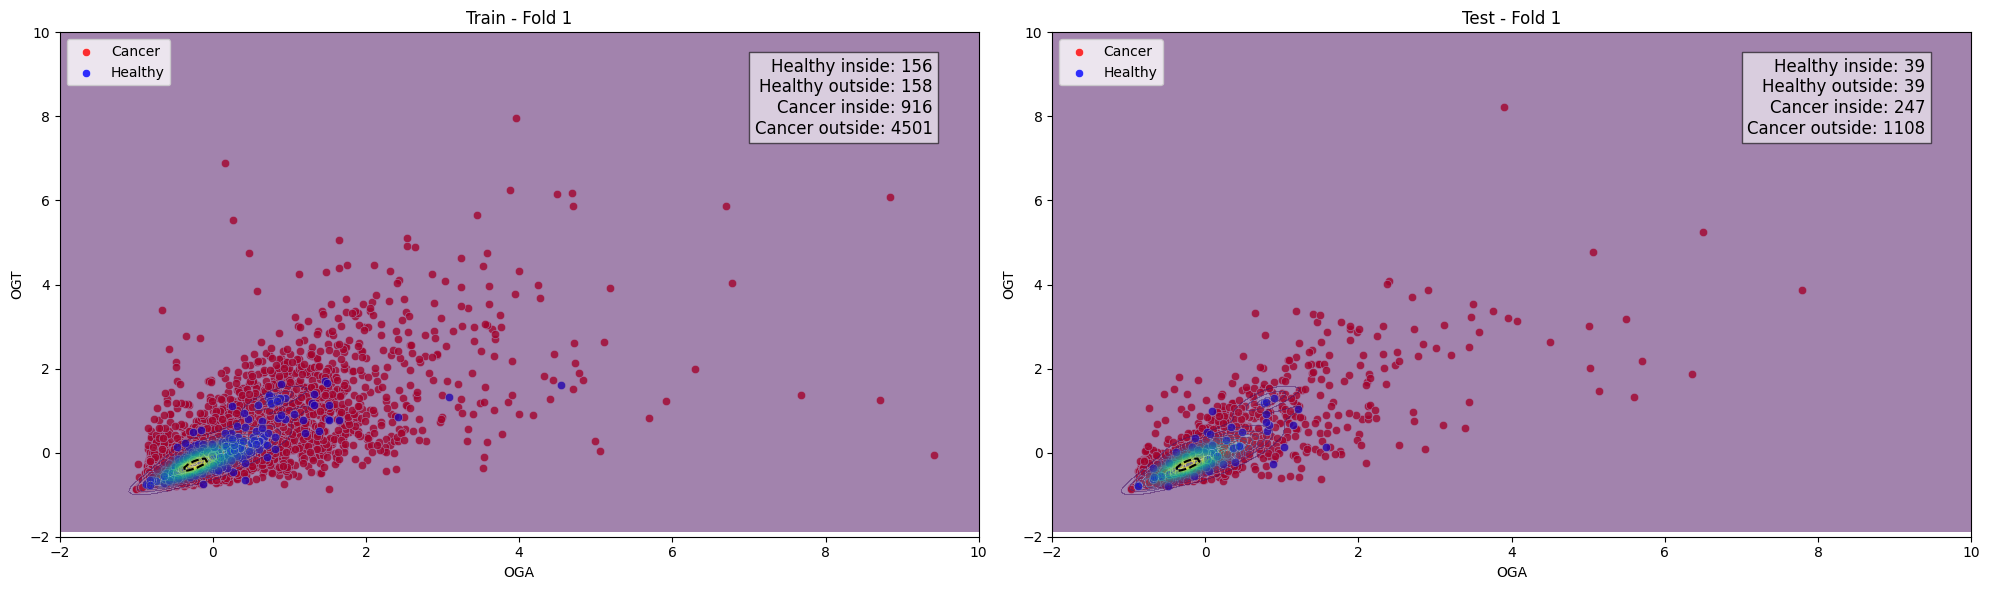

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


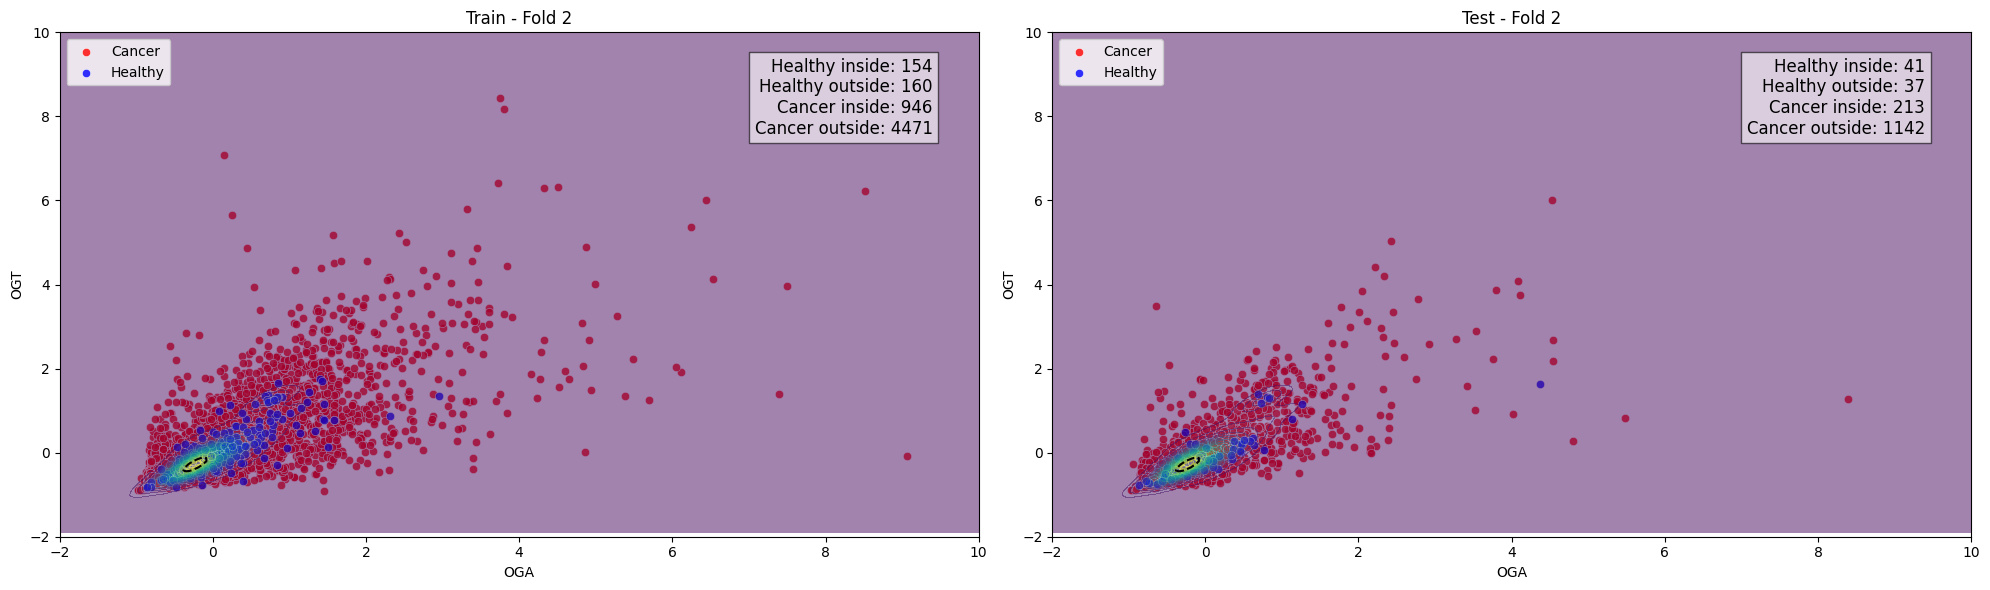

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


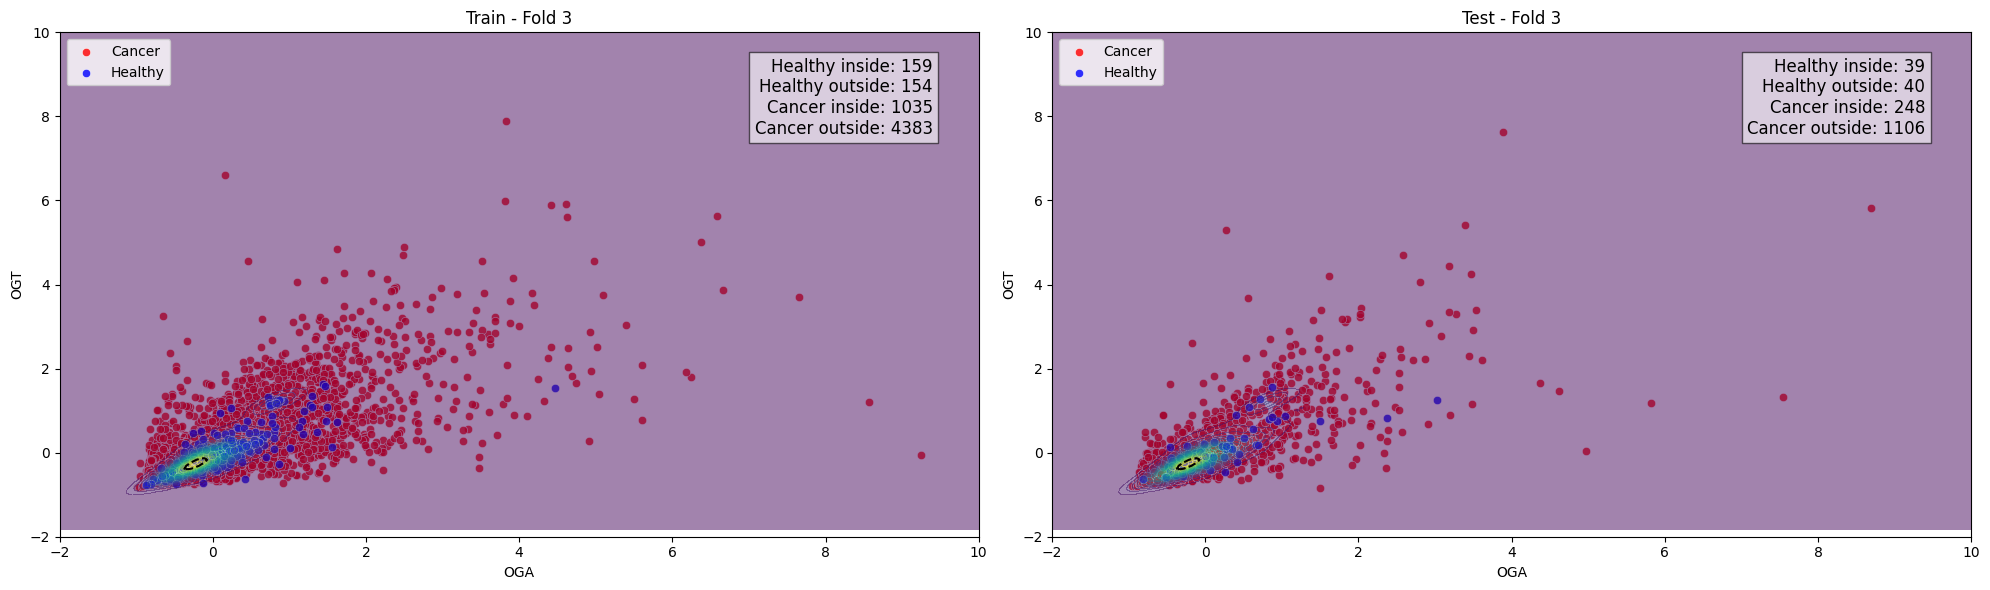

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


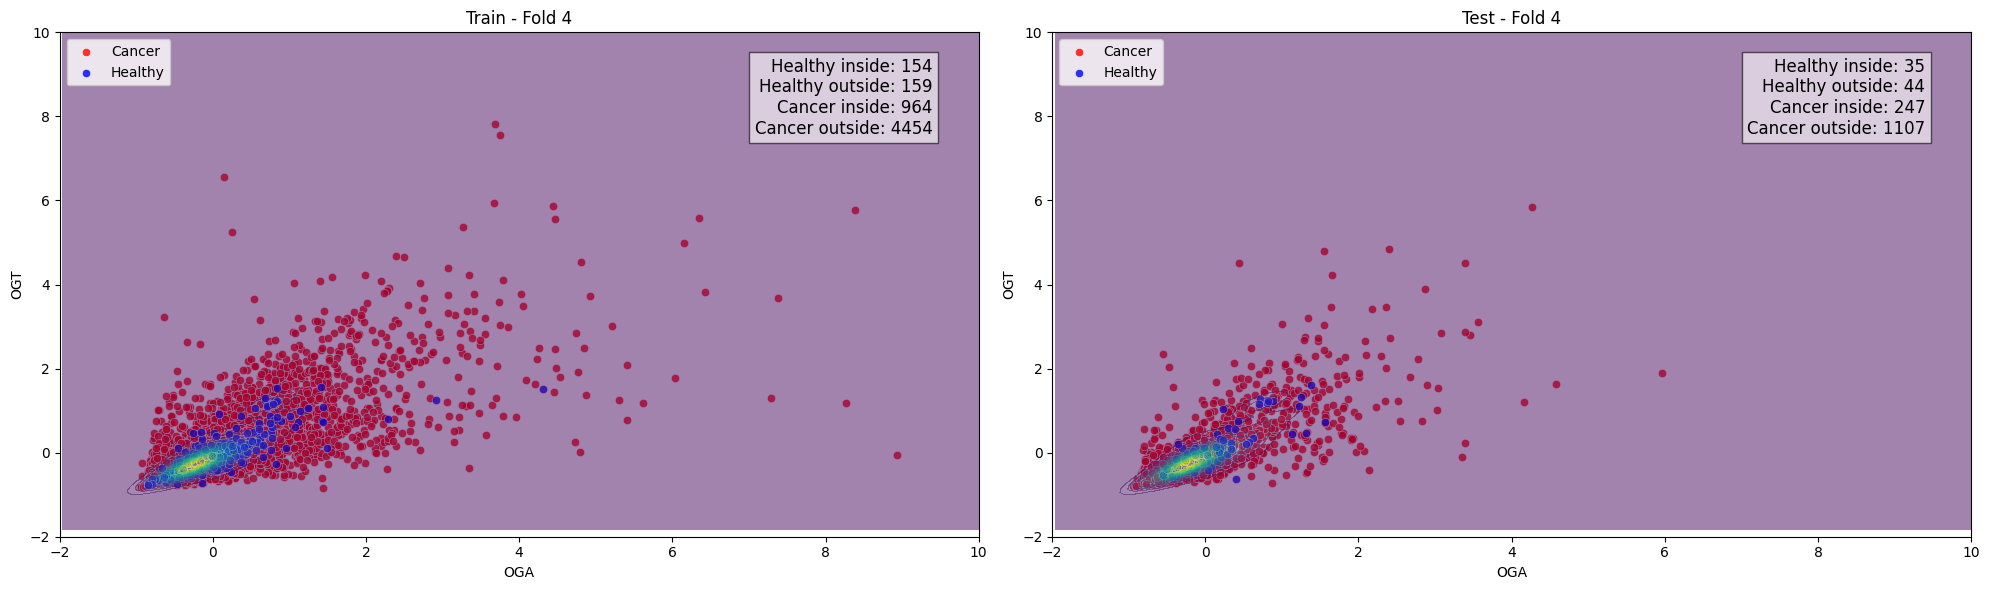

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


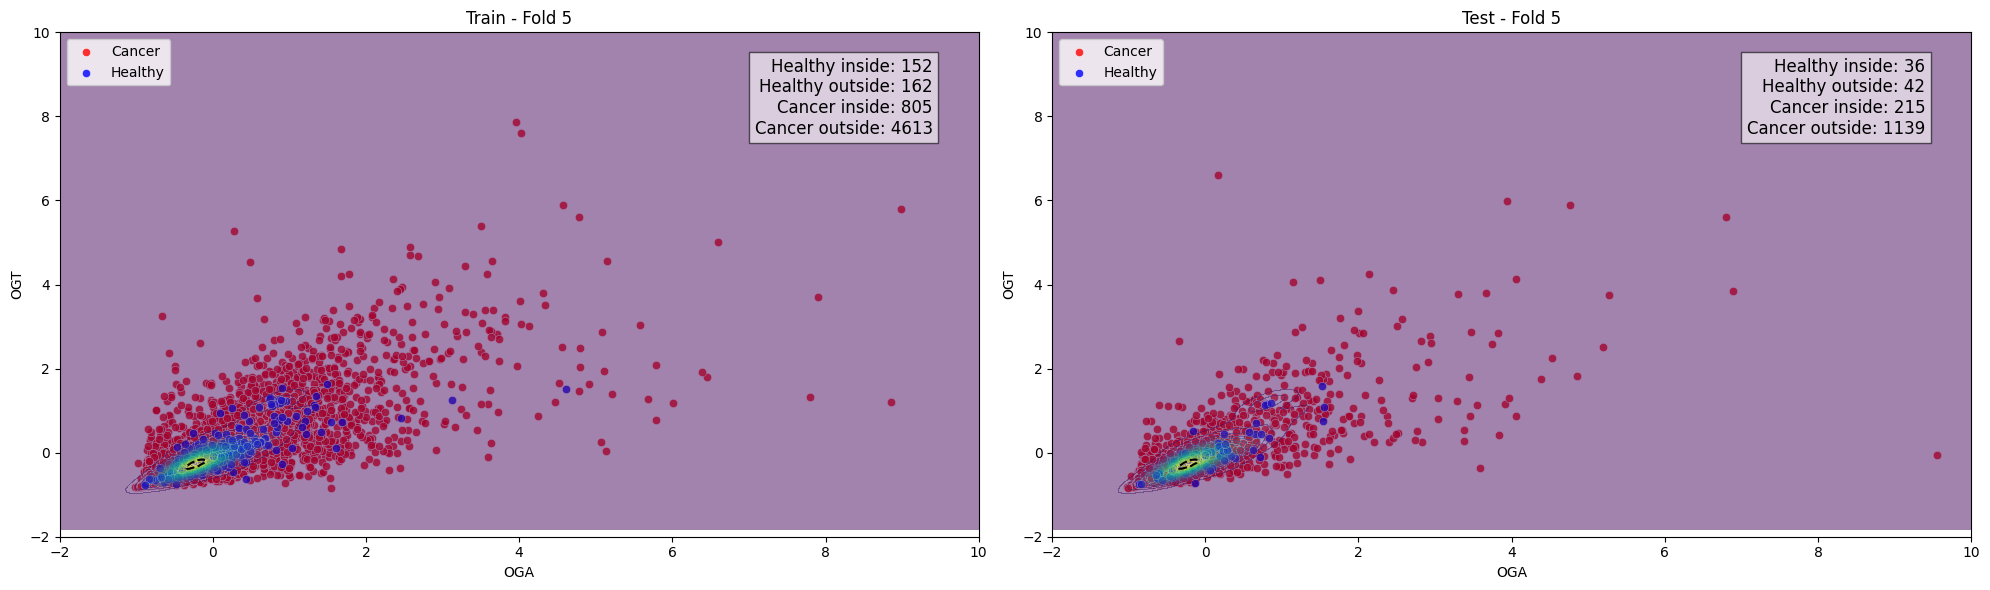

In [8]:
# Assign O-GlcNAcylation dysregulation values to each sample (from train set) and visualize the results
updated_results_bmb = plot_and_assign_dysregulation(results_bmb, column_name='cancer_type', zoom_limits=[10, 10])


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


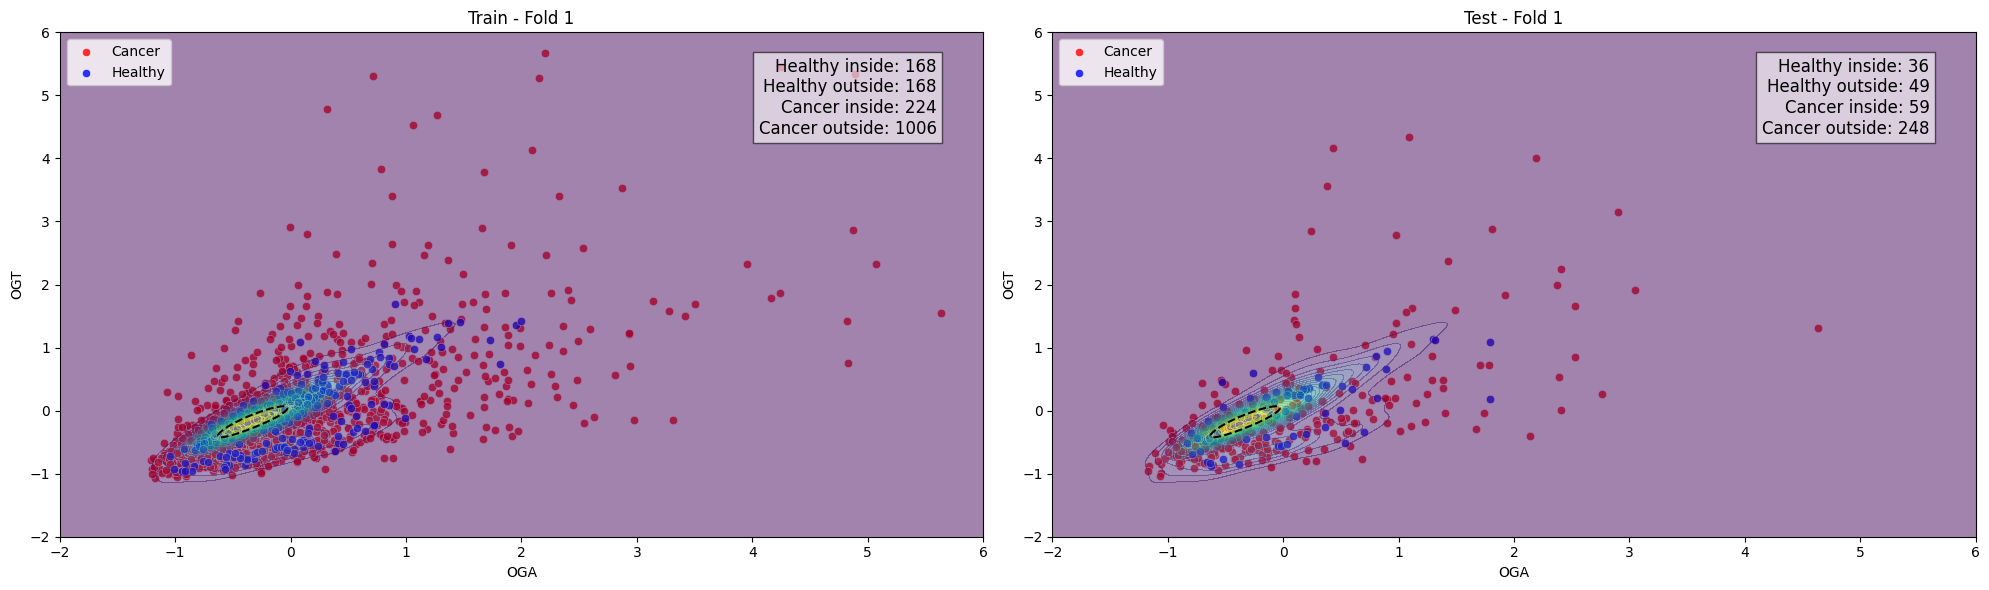

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


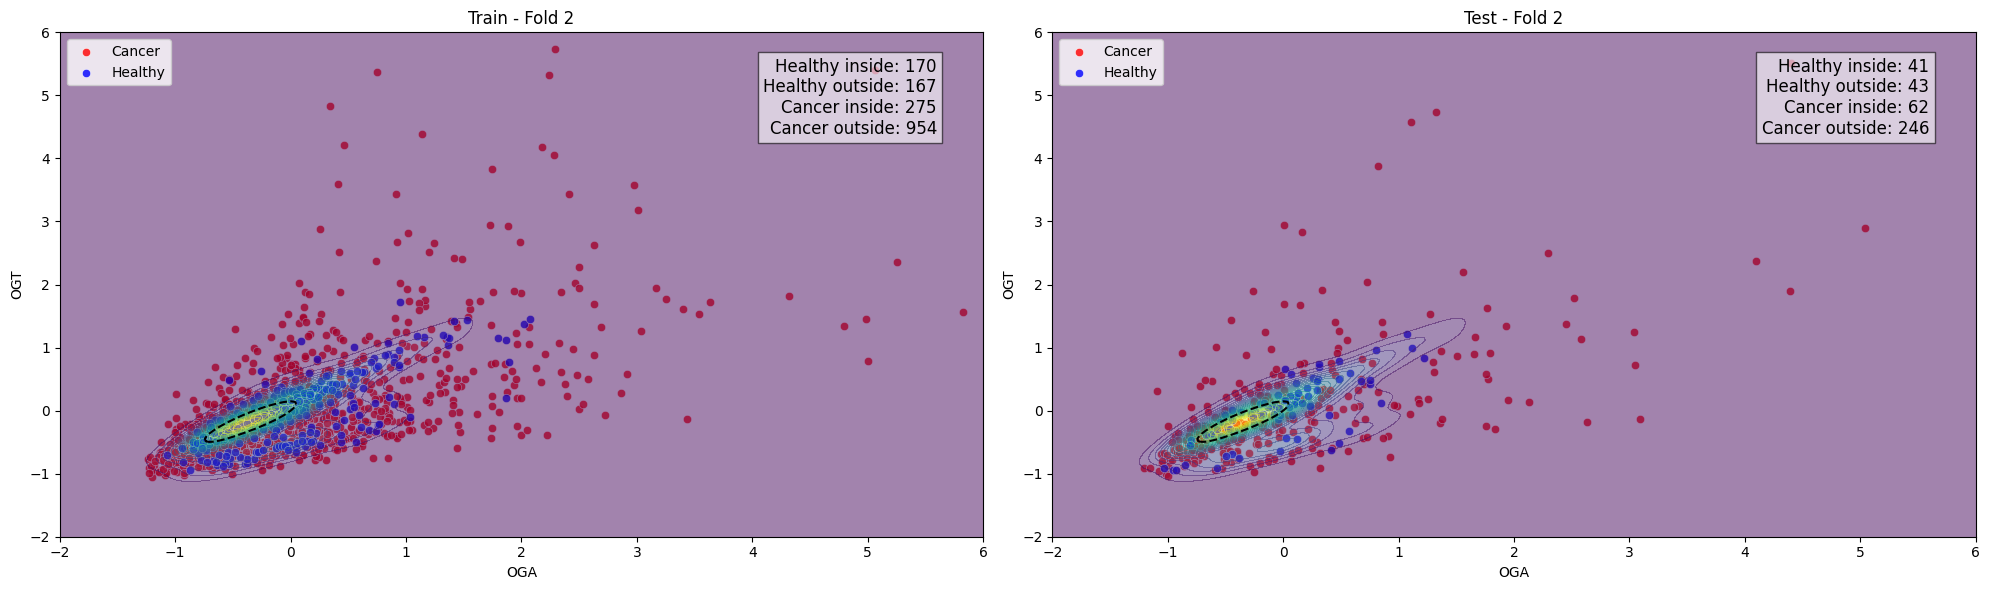

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


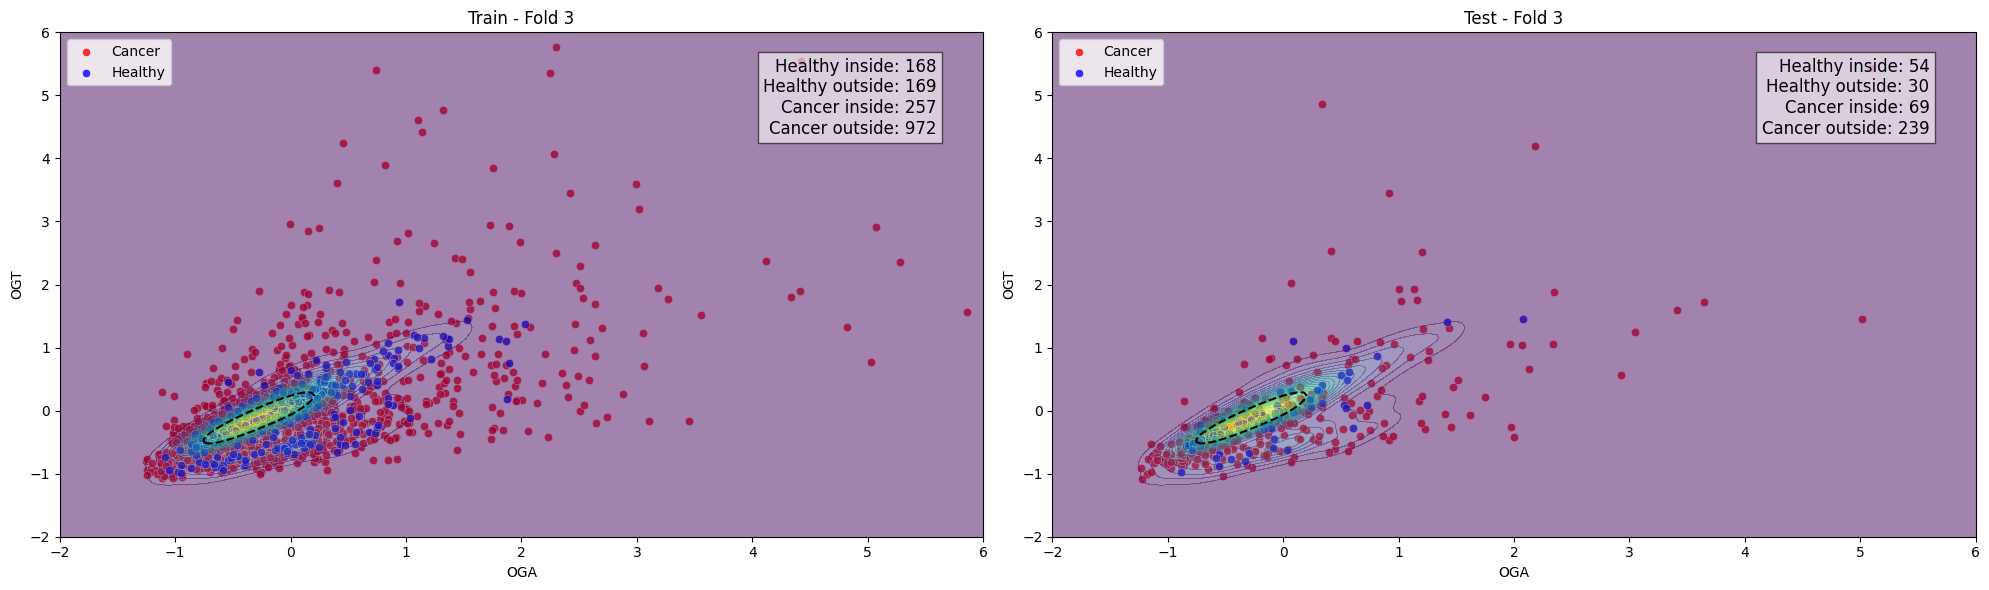

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


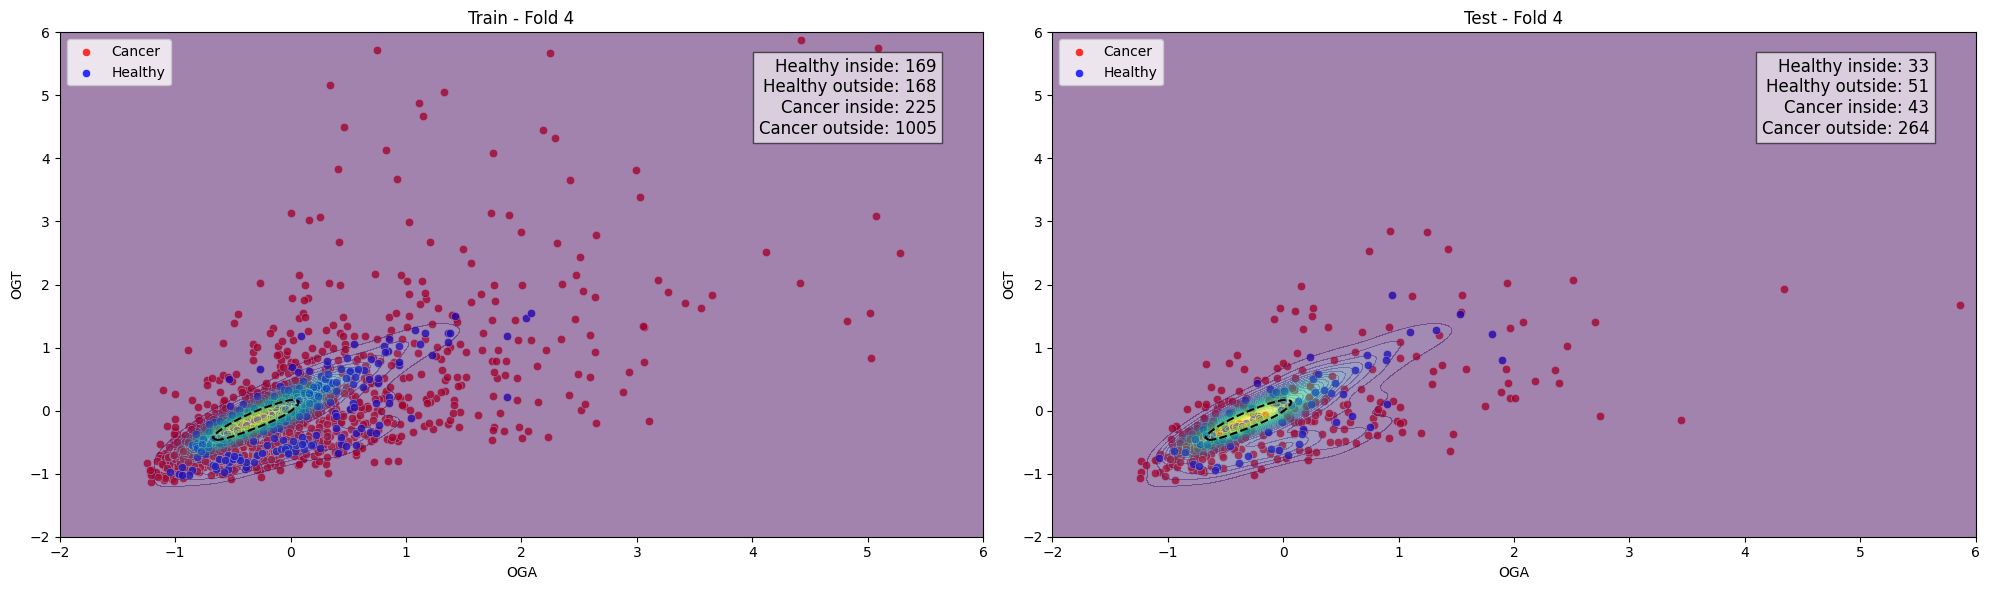

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


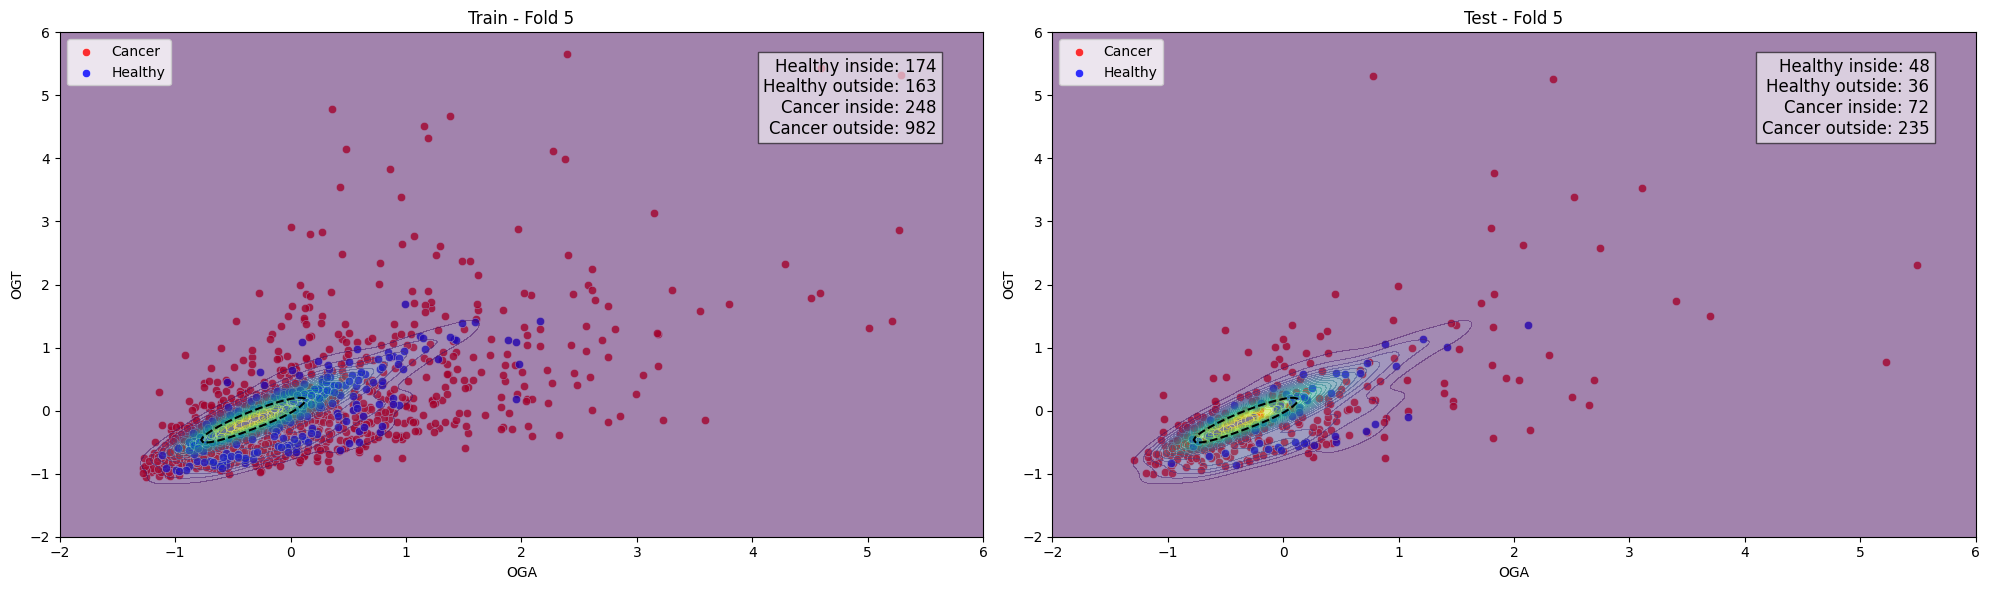

In [9]:
# Assign O-GlcNAcylation dysregulation values to each sample (from train set) and visualize the results
updated_results_lng = plot_and_assign_dysregulation(results_lng, column_name='cancer_stage', zoom_limits=[6, 6])


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


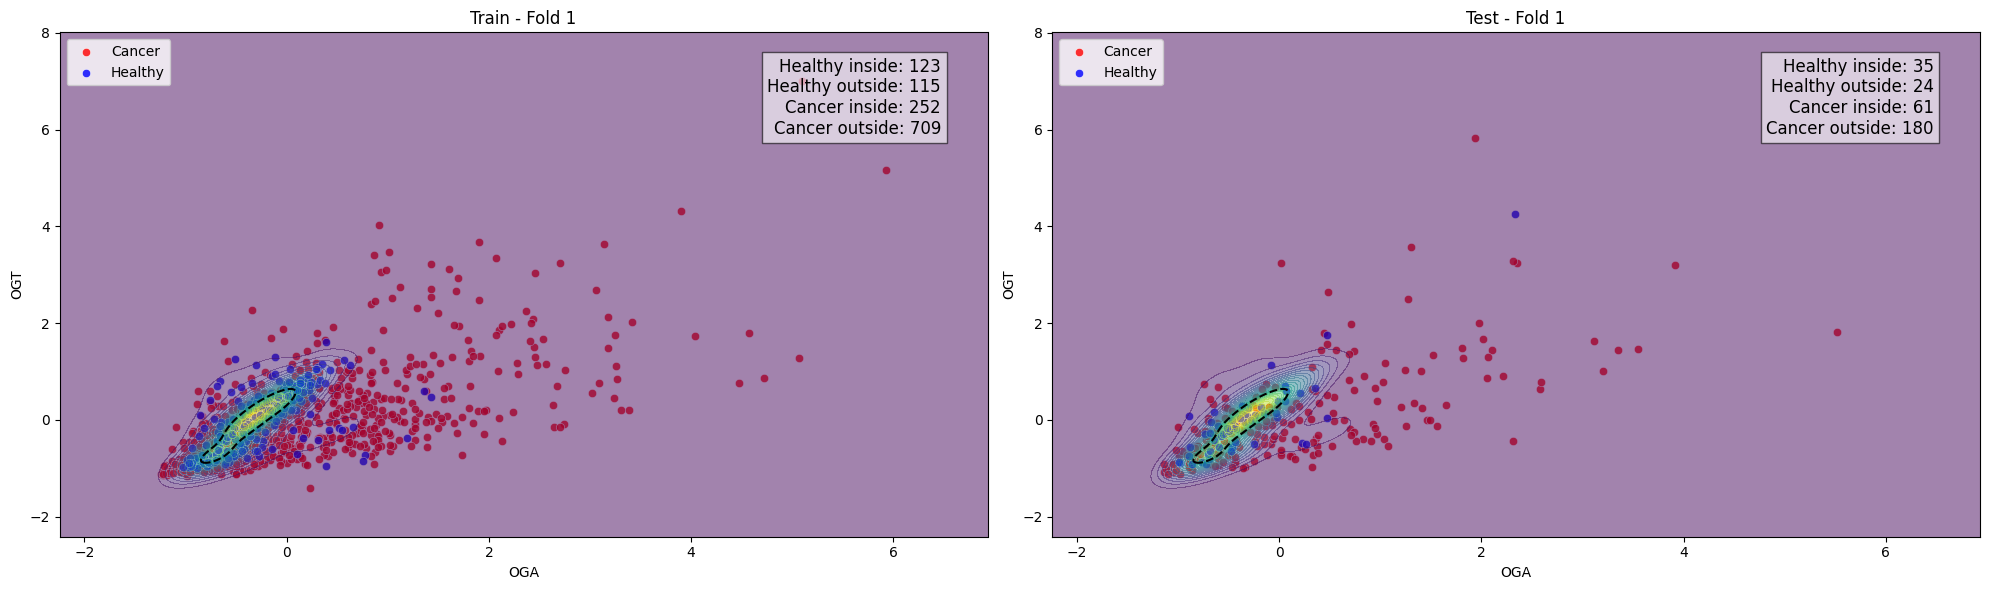

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


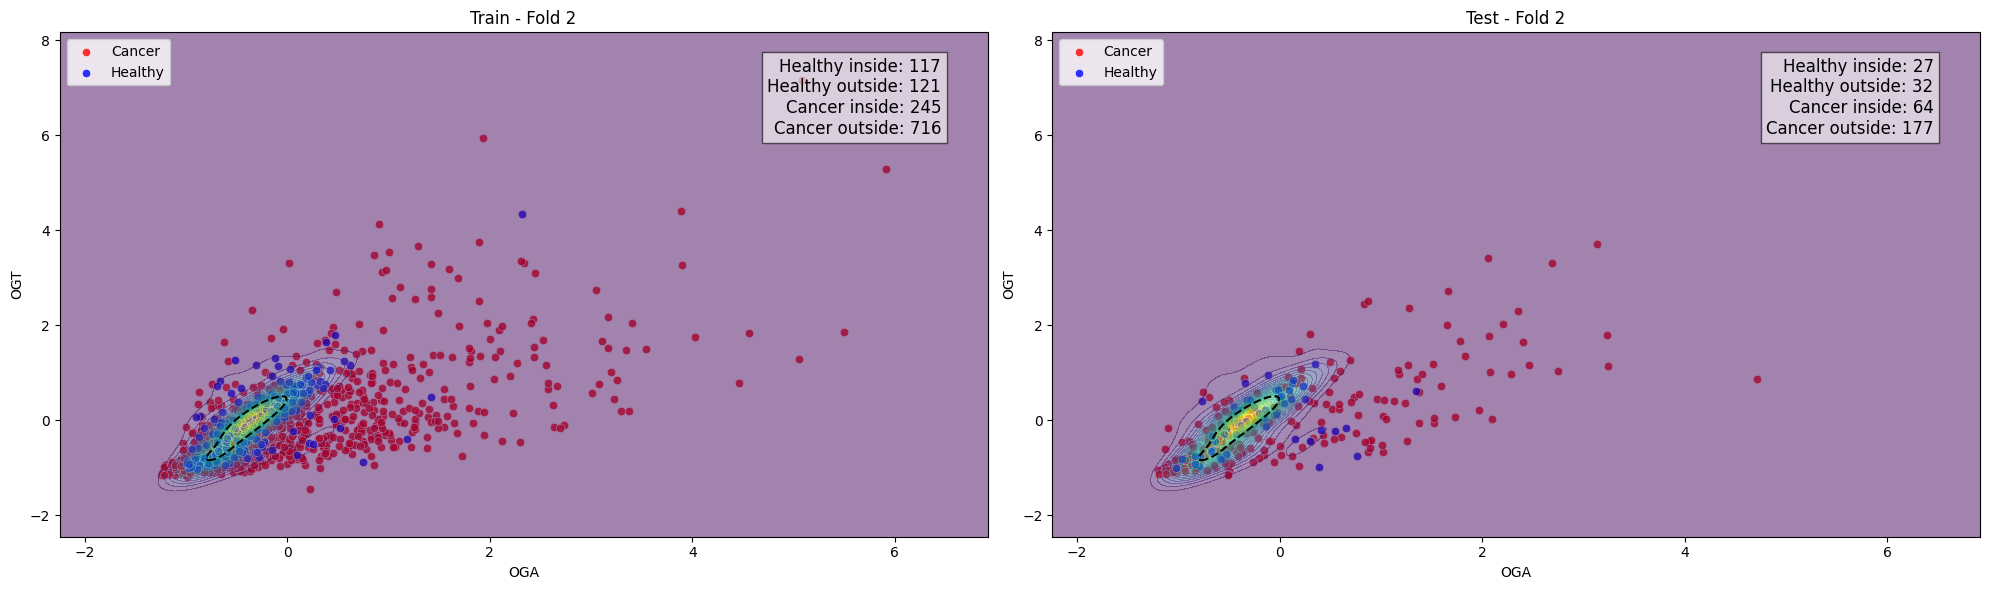

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


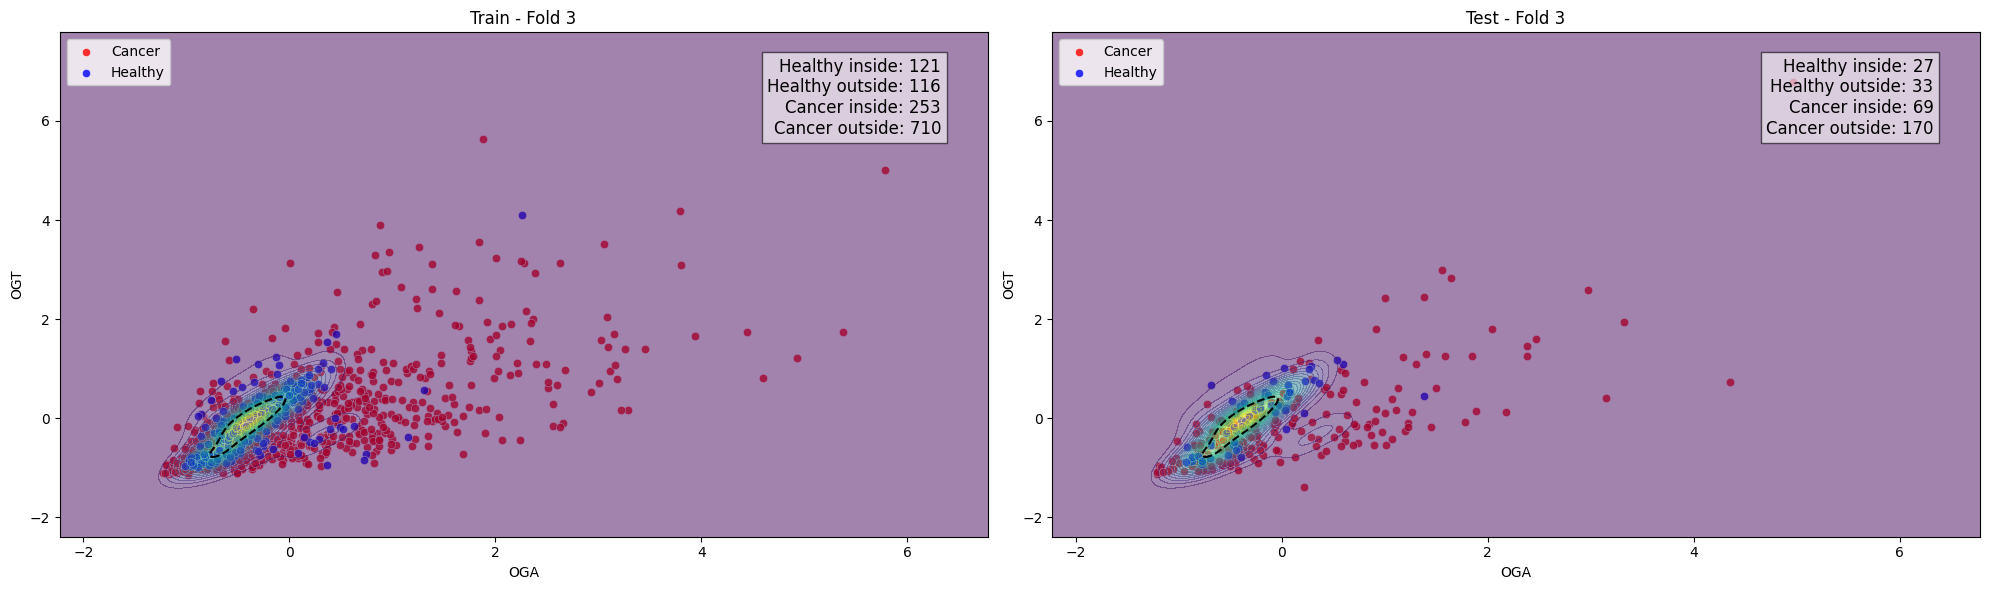

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


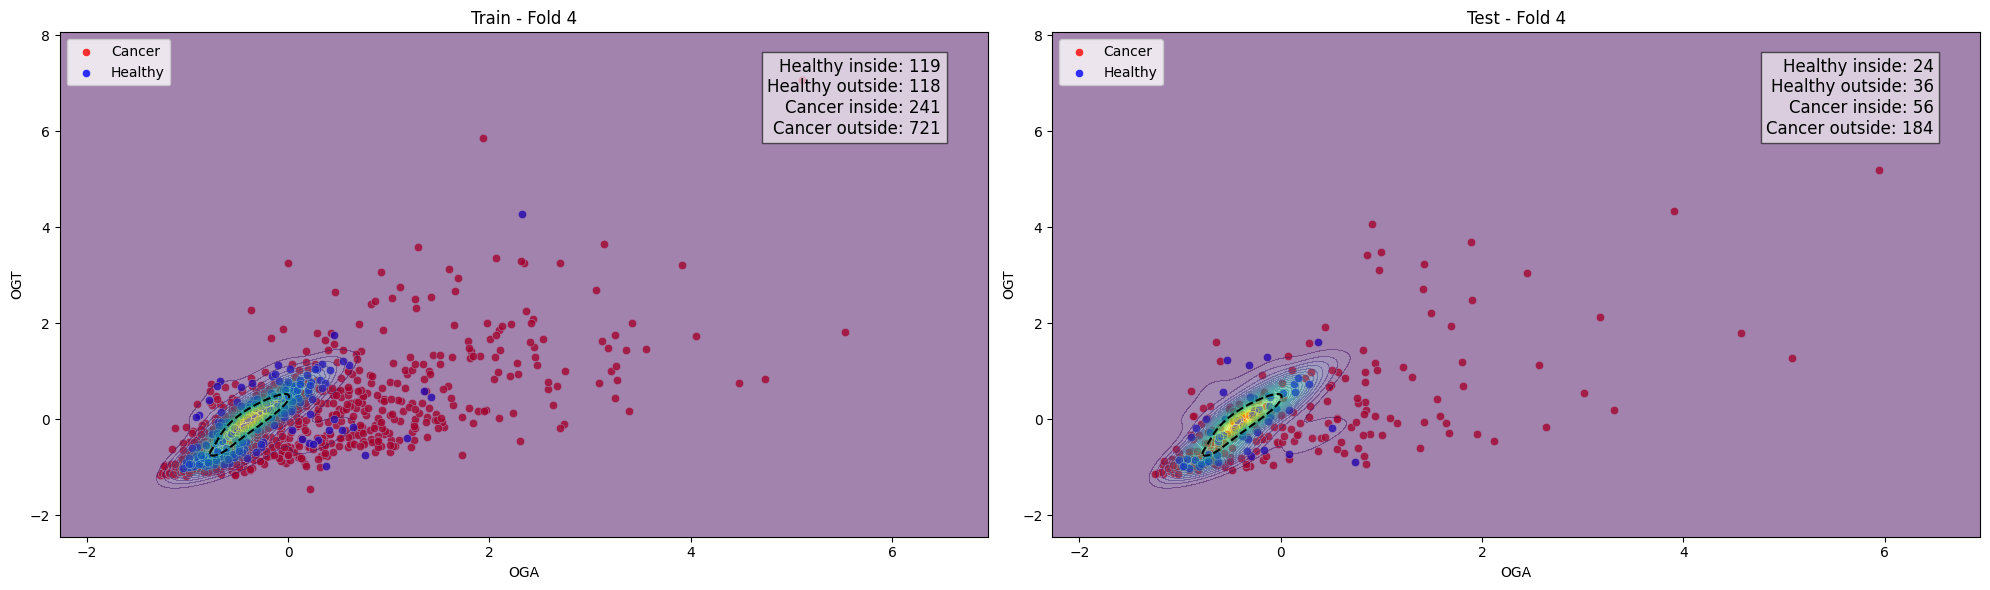

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


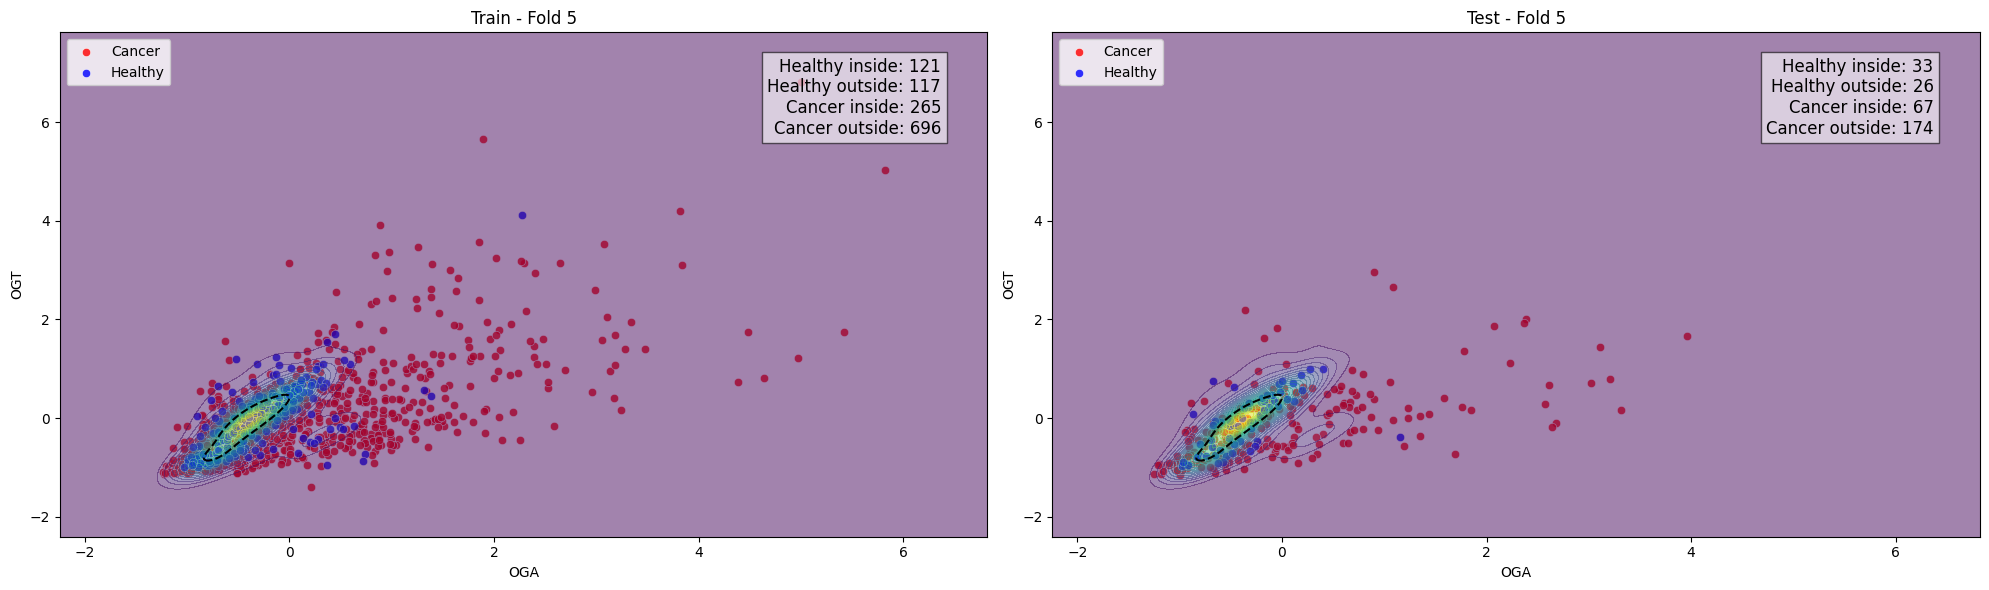

In [10]:
# Assign O-GlcNAcylation dysregulation values to each sample (from train set) and visualize the results
updated_results_kid = plot_and_assign_dysregulation(results_kid, column_name='cancer_stage')


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


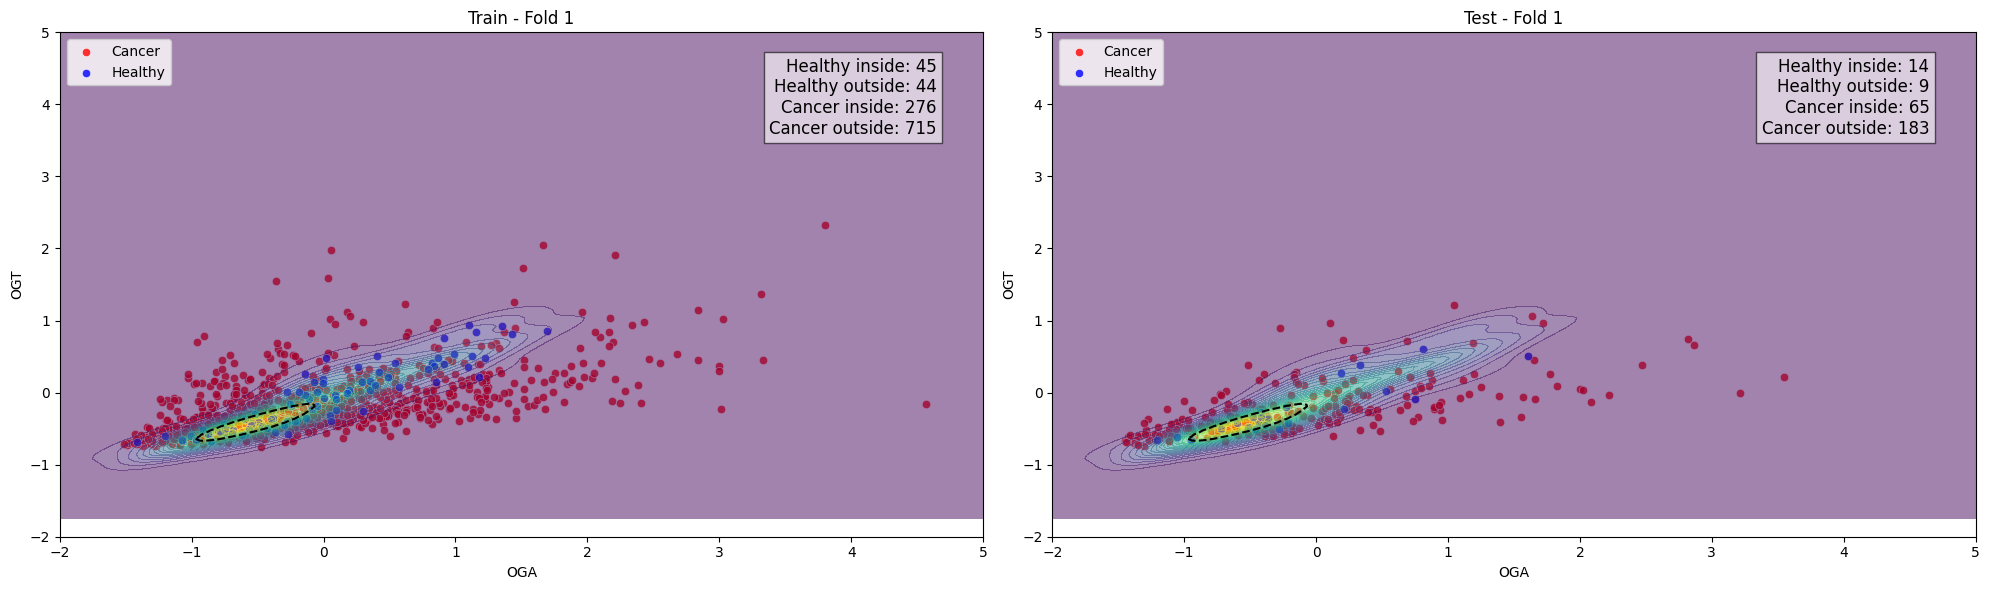

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


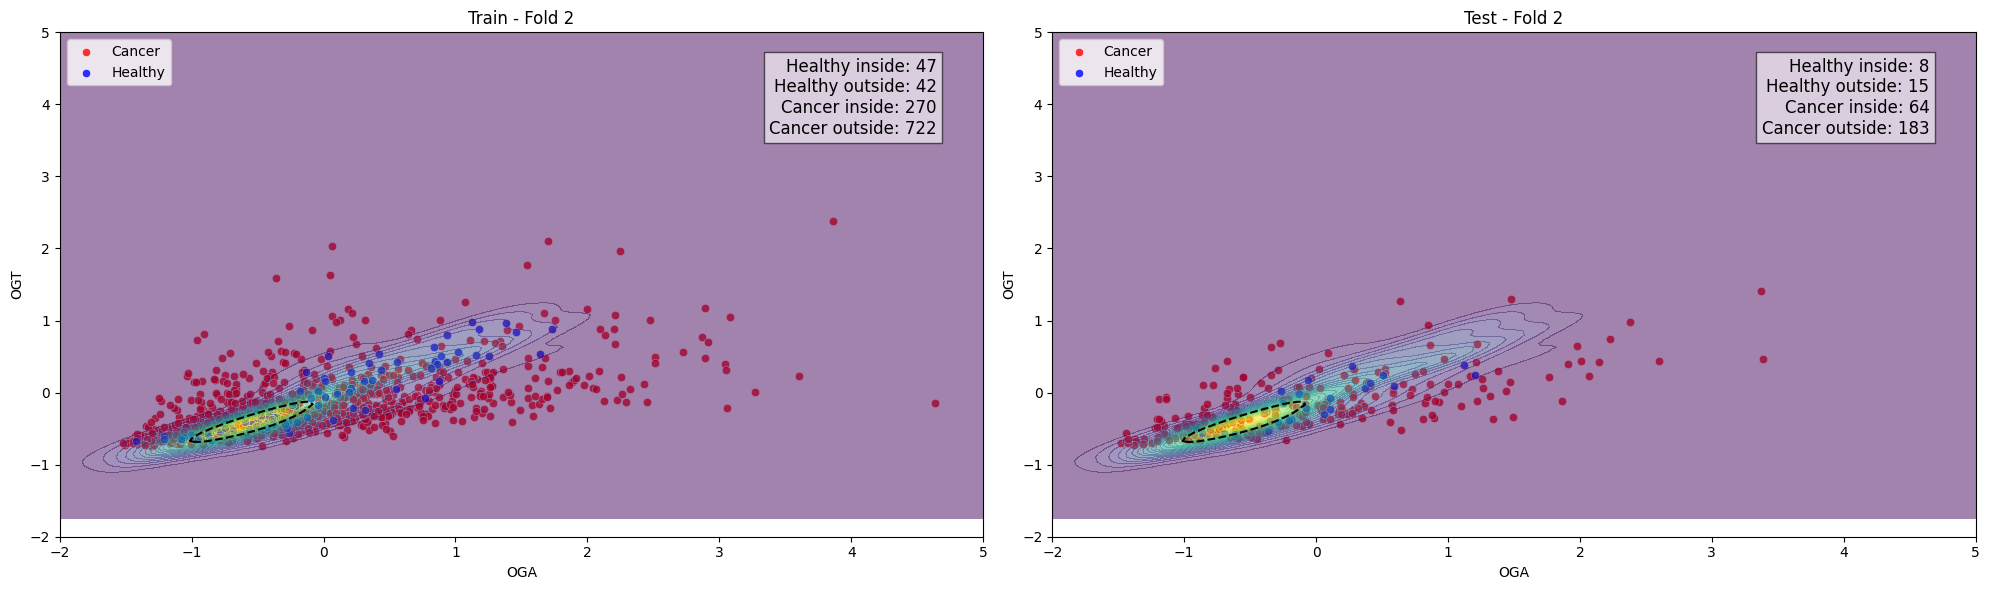

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


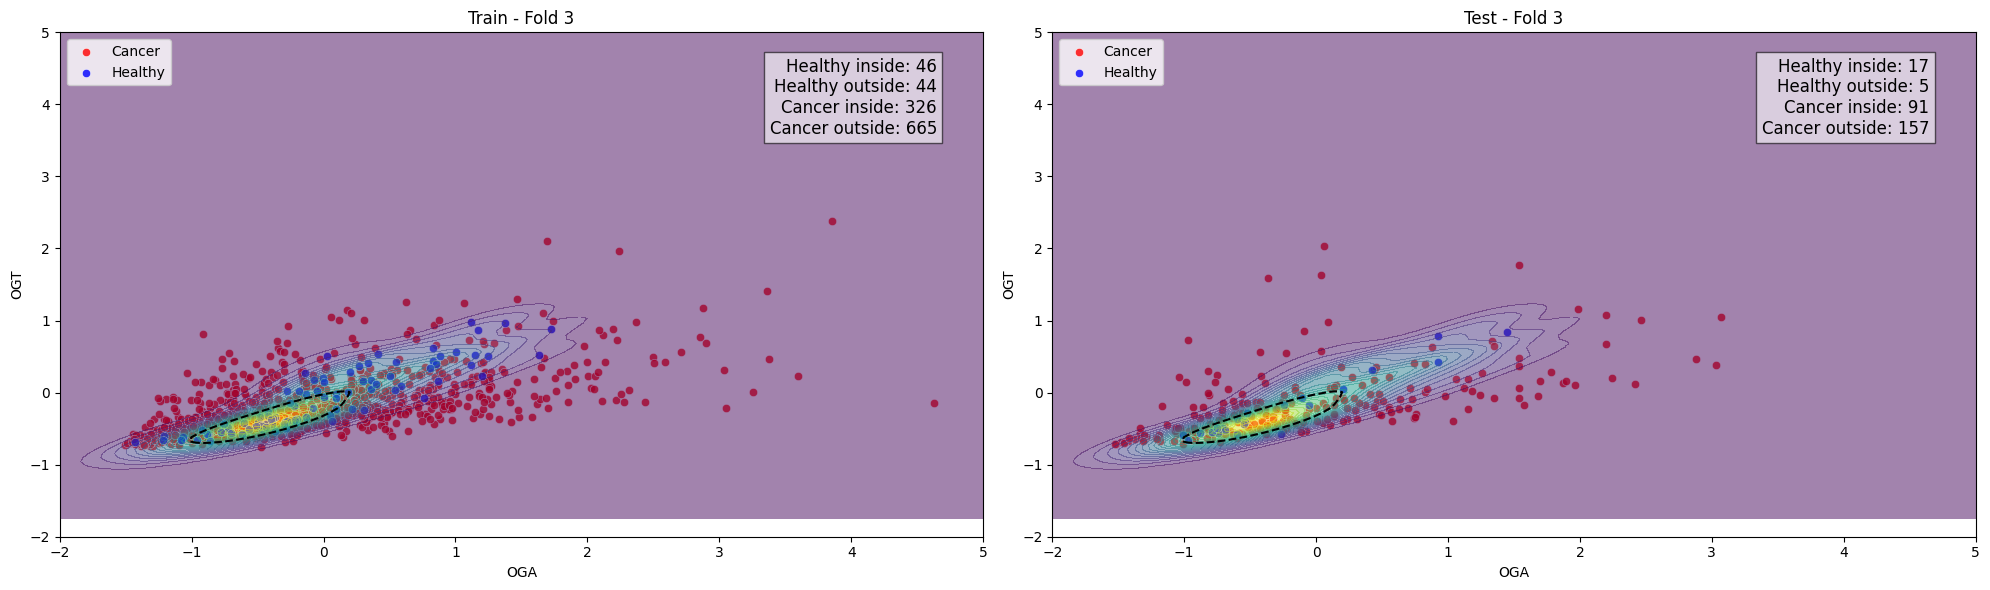

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


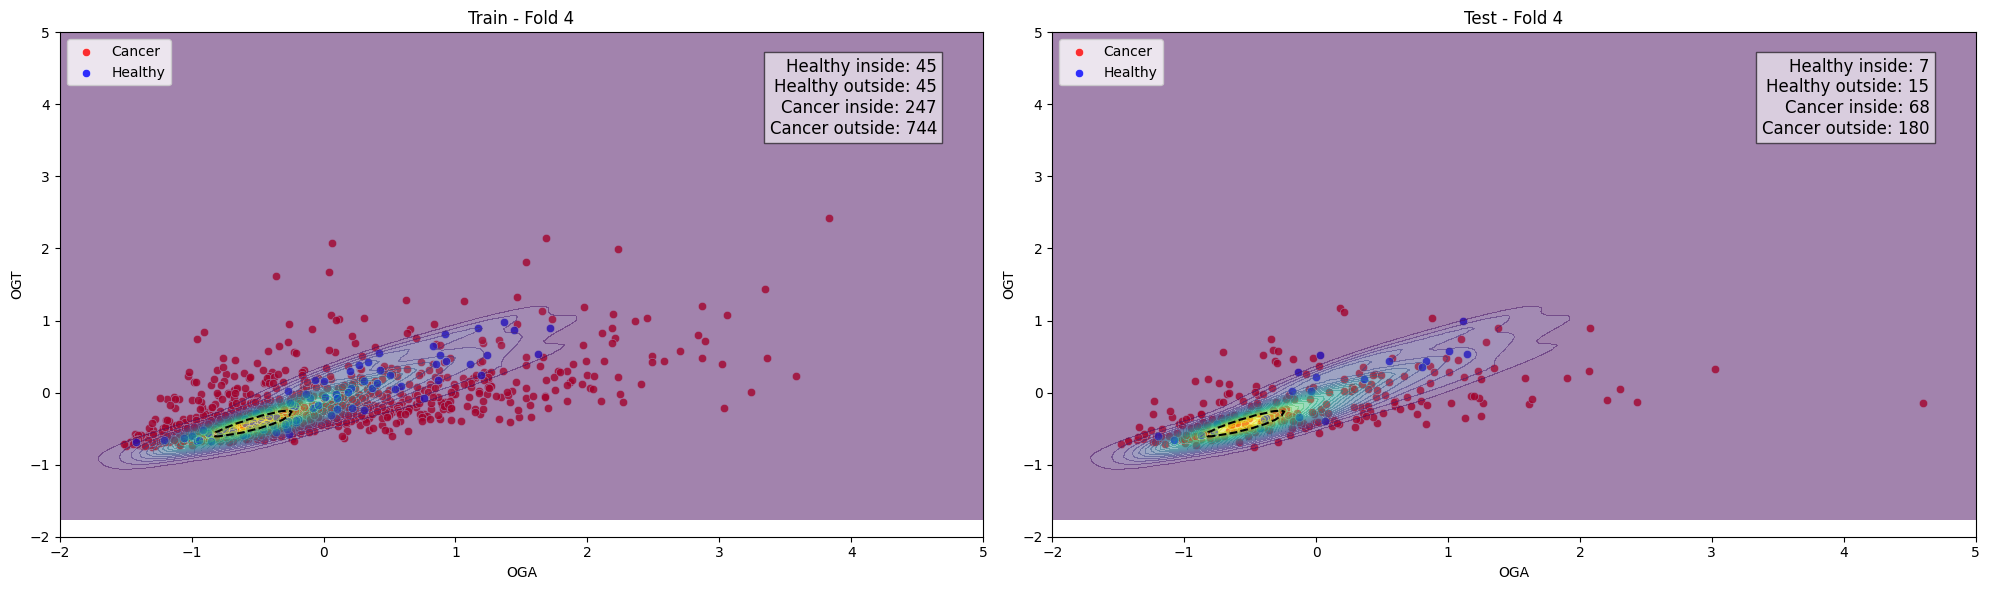

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


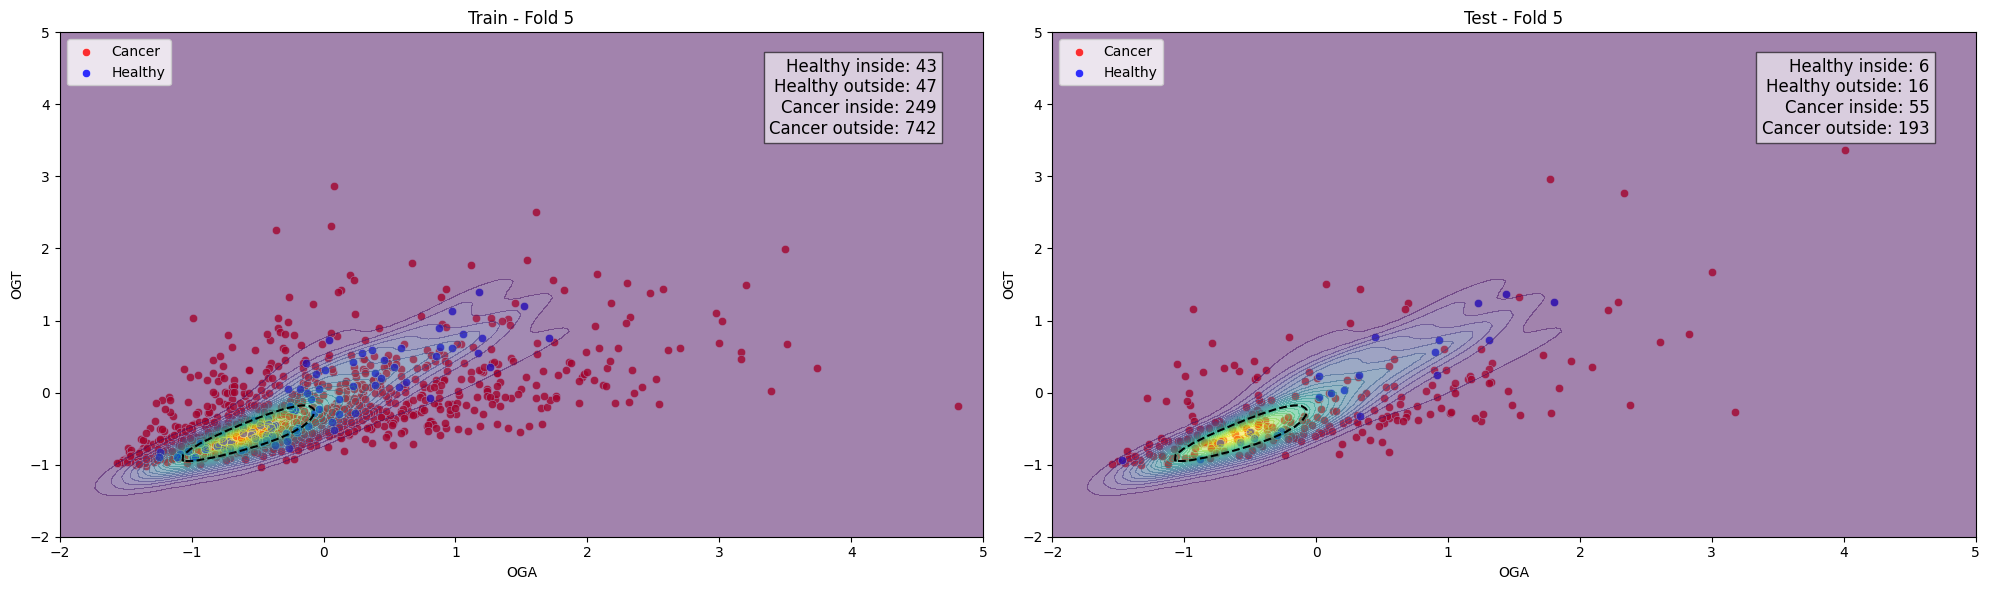

In [11]:
# Assign O-GlcNAcylation dysregulation values to each sample (from train set) and visualize the results
updated_results_brs = plot_and_assign_dysregulation(results_brs, column_name='cancer_stage', zoom_limits=[5, 5])


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


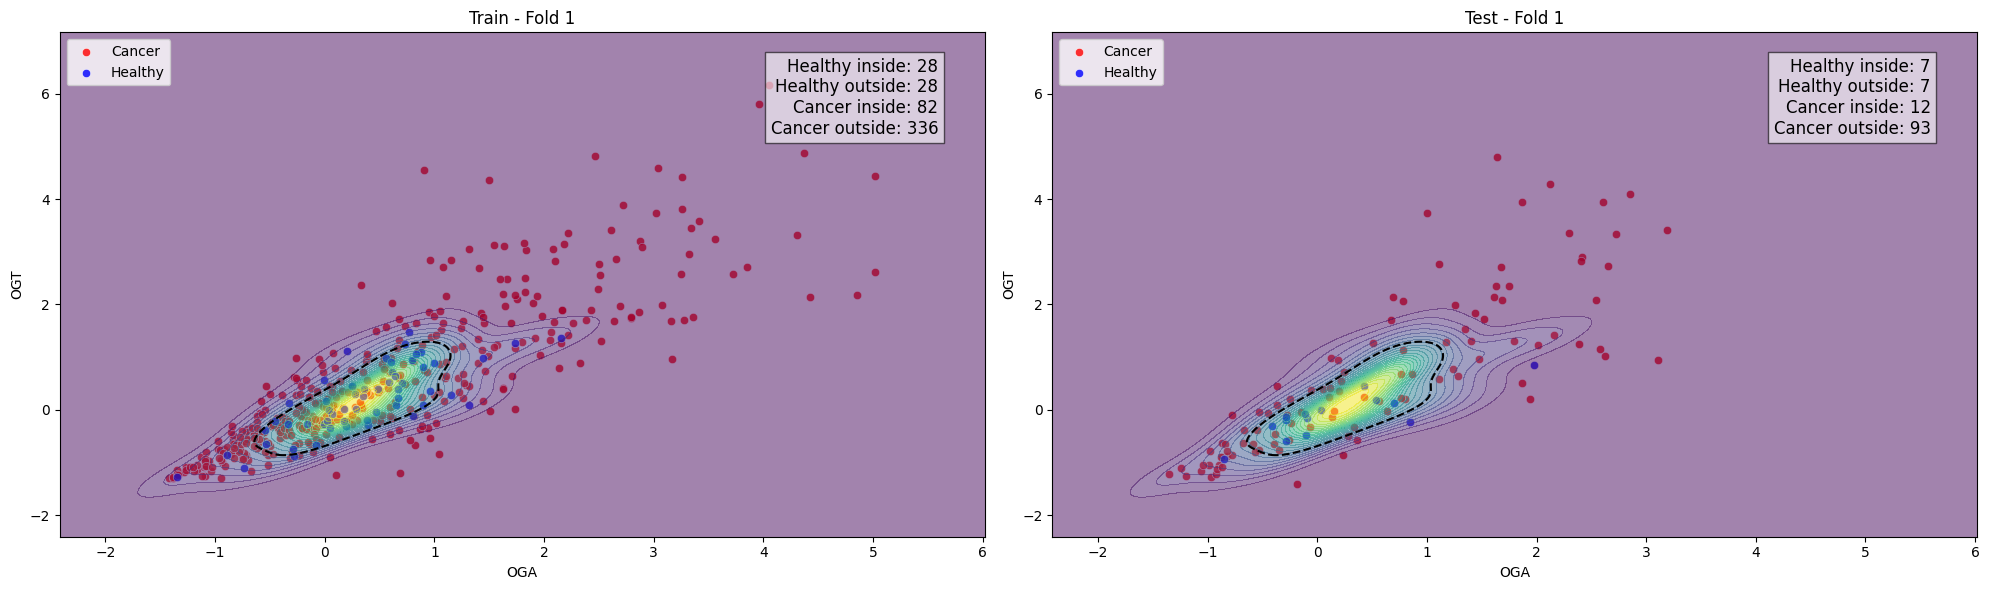

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


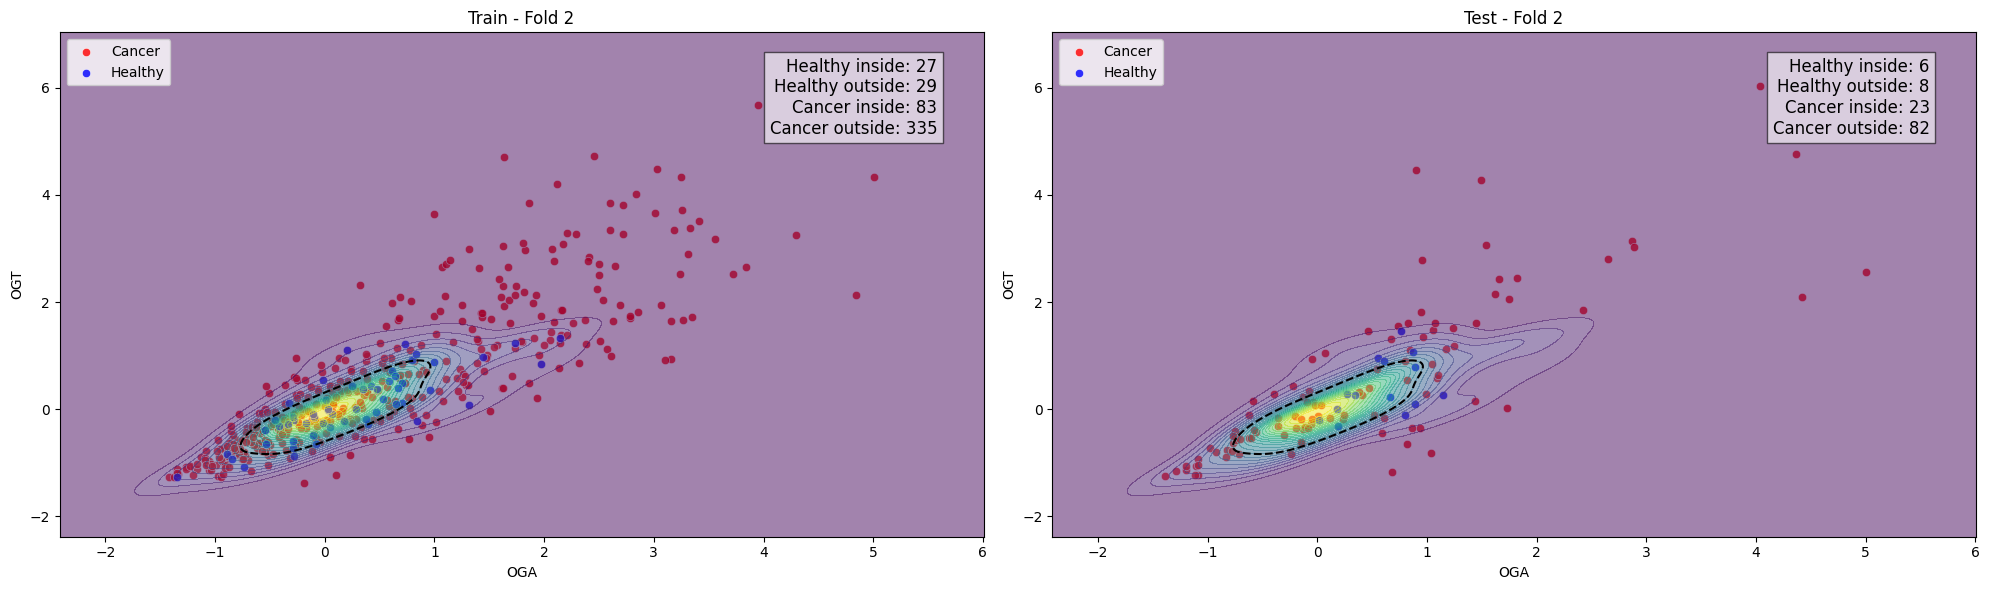

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


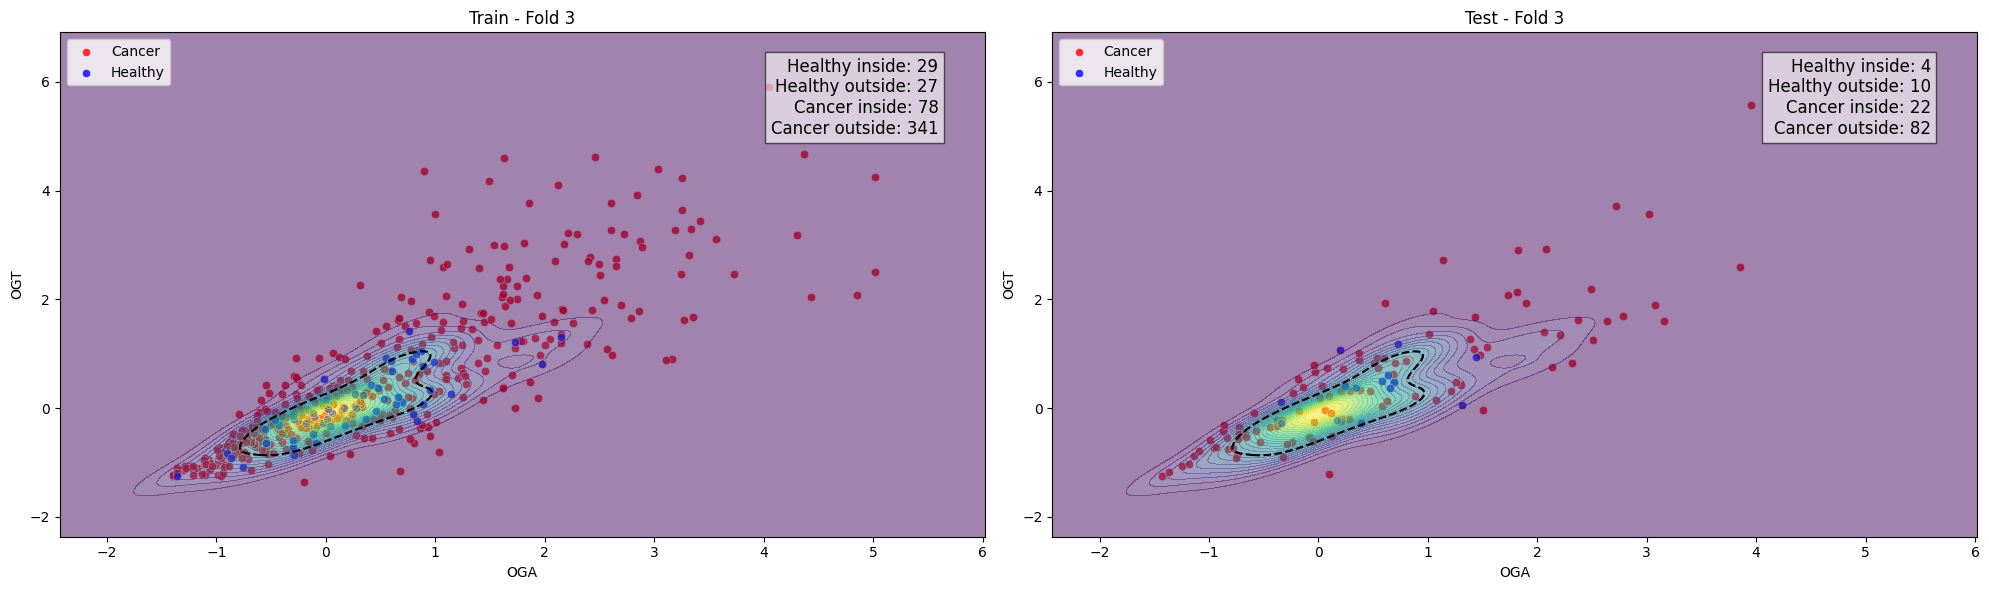

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


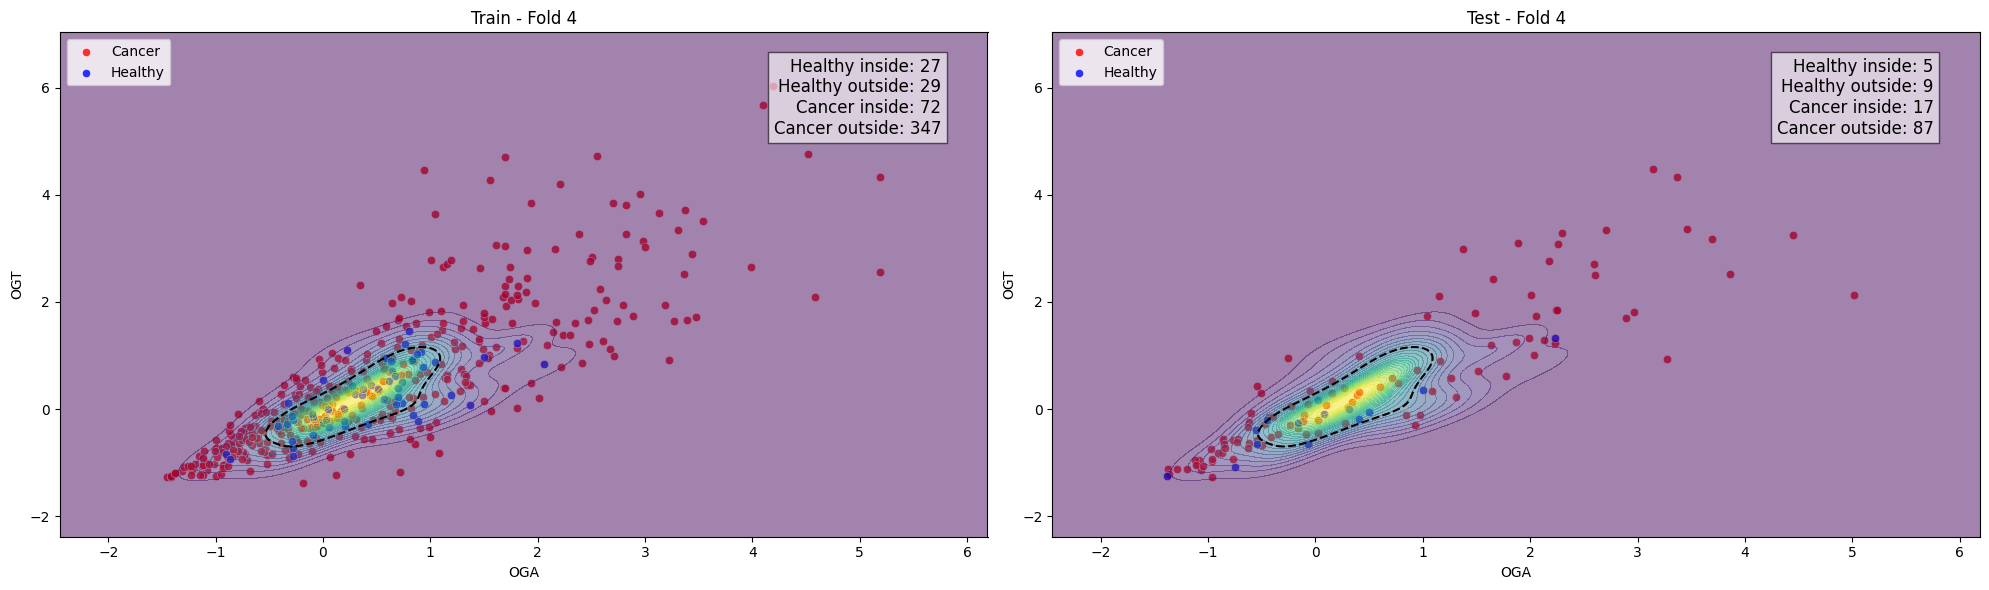

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


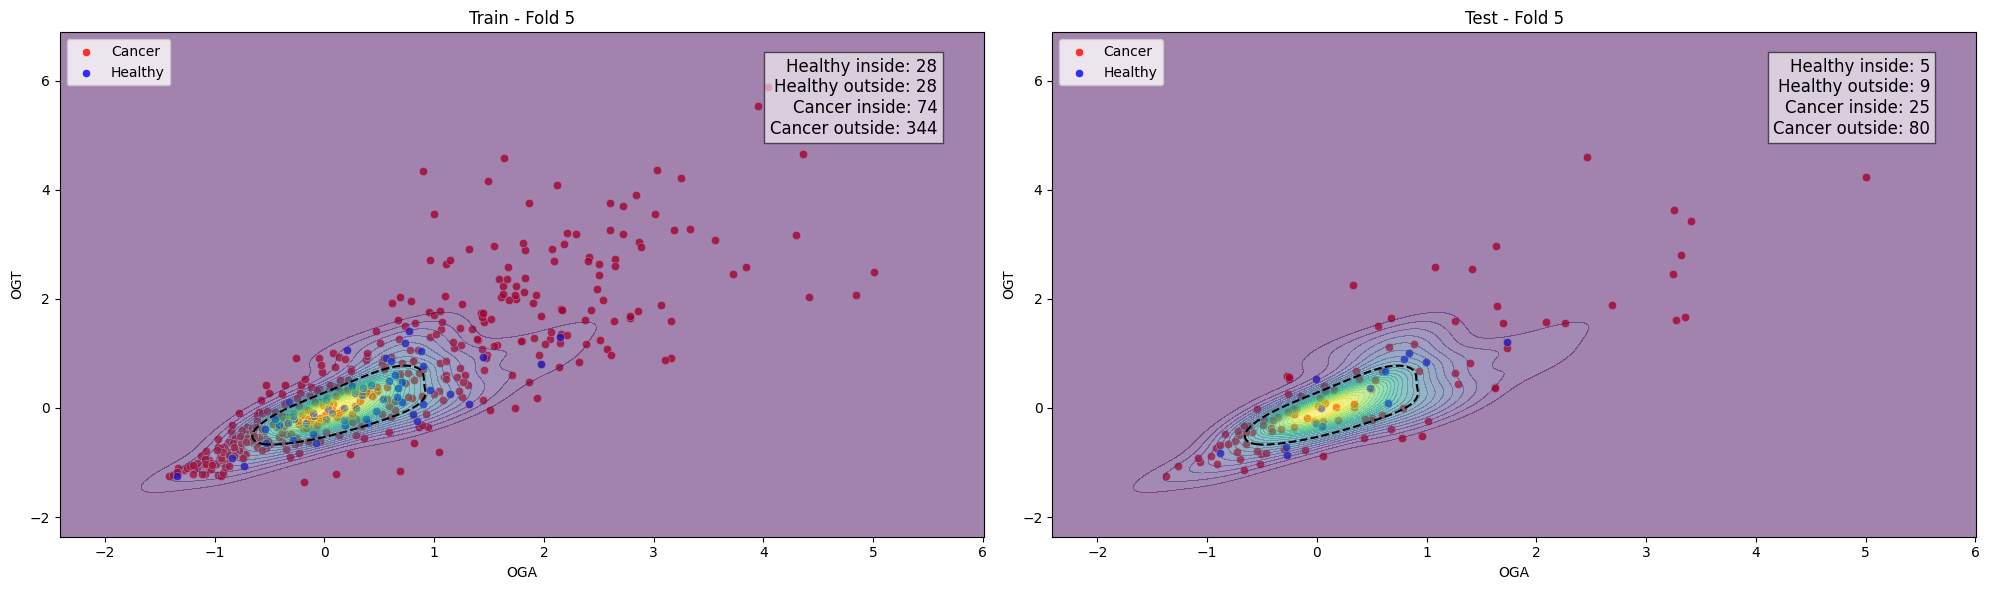

In [12]:
# Assign O-GlcNAcylation dysregulation values to each sample (from train set) and visualize the results
updated_results_thy = plot_and_assign_dysregulation(results_thy, column_name='cancer_stage')#, zoom_limits=[5, 5])


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


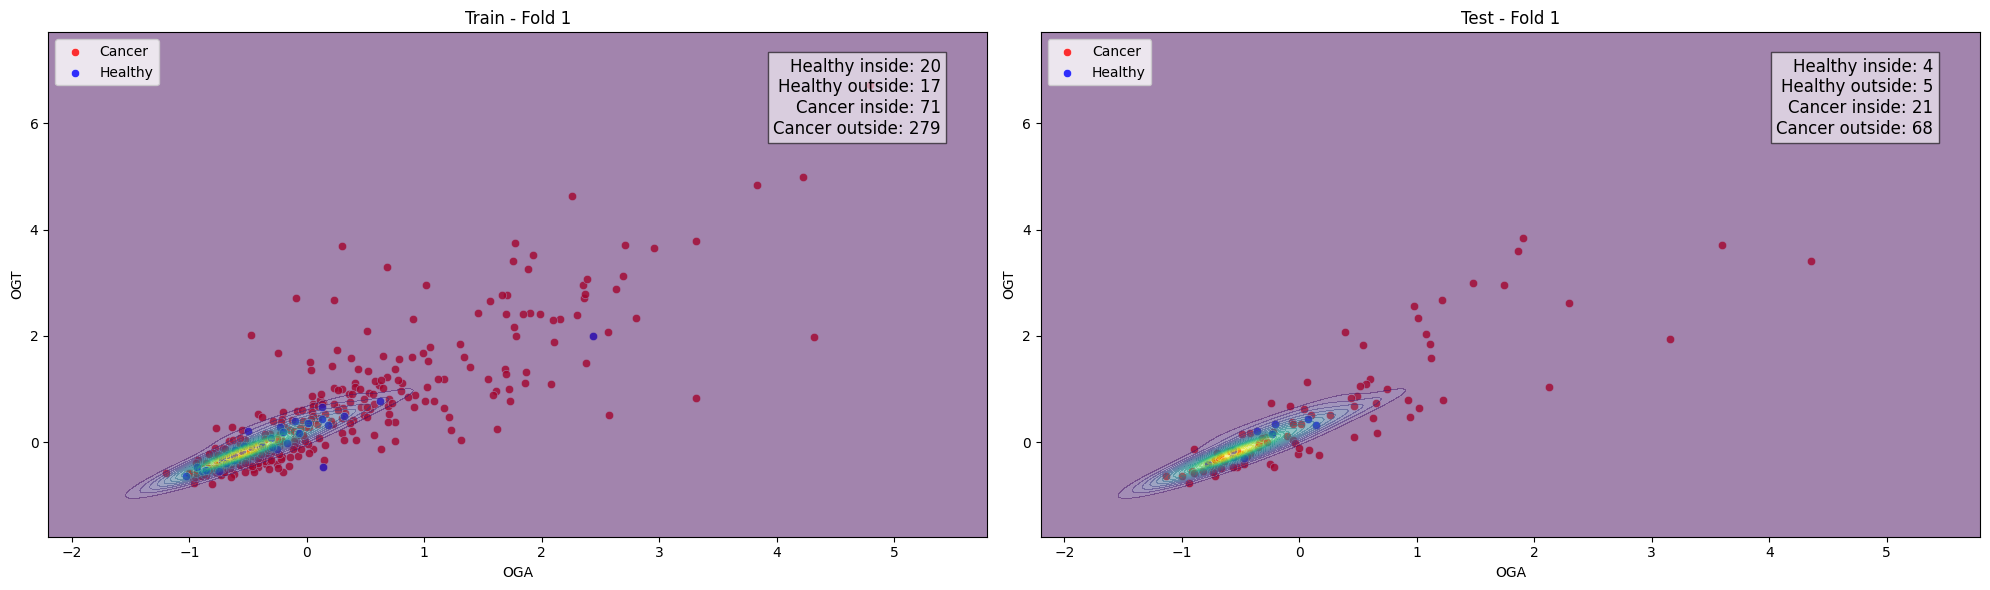

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


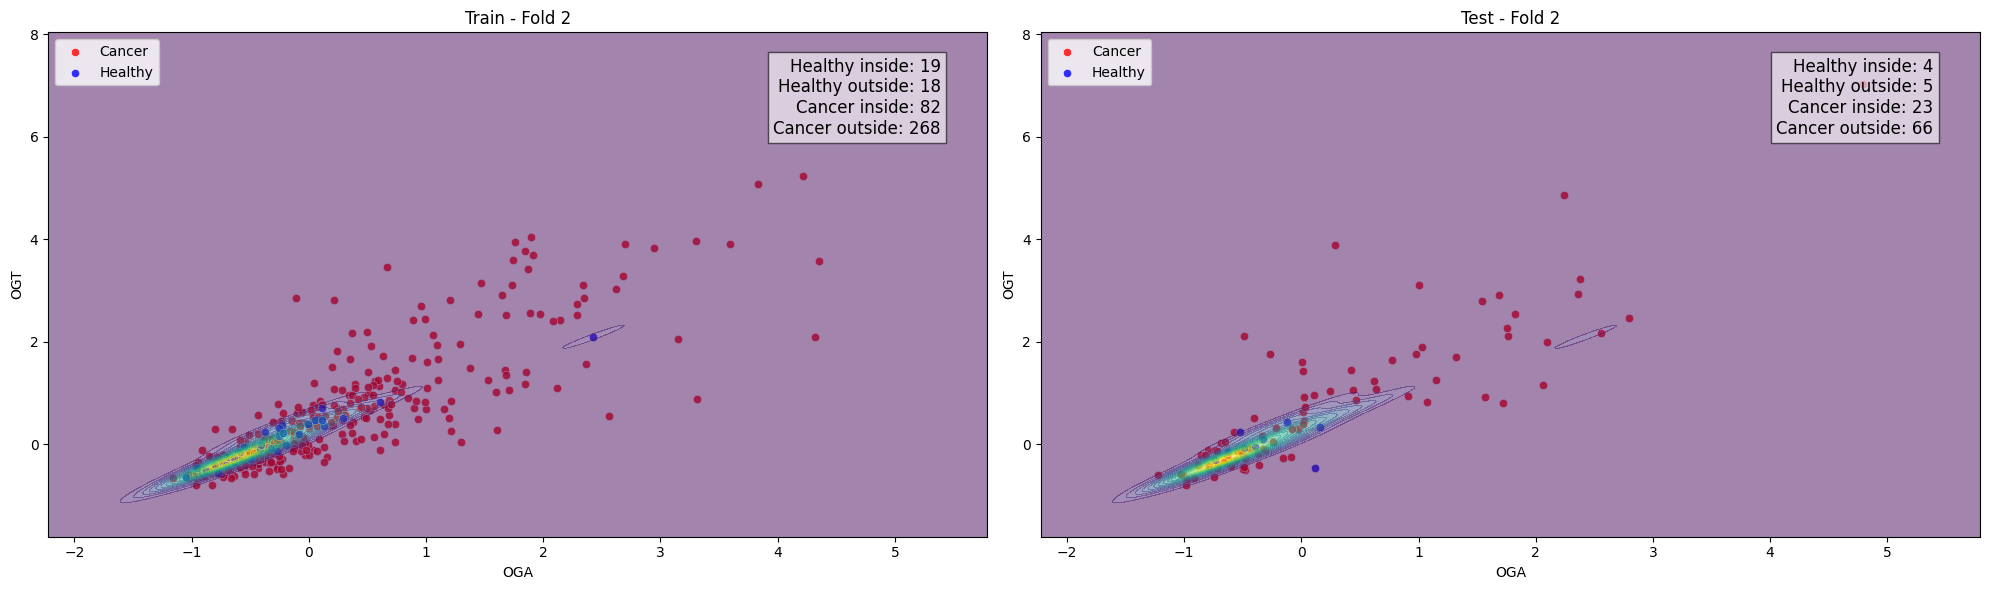

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


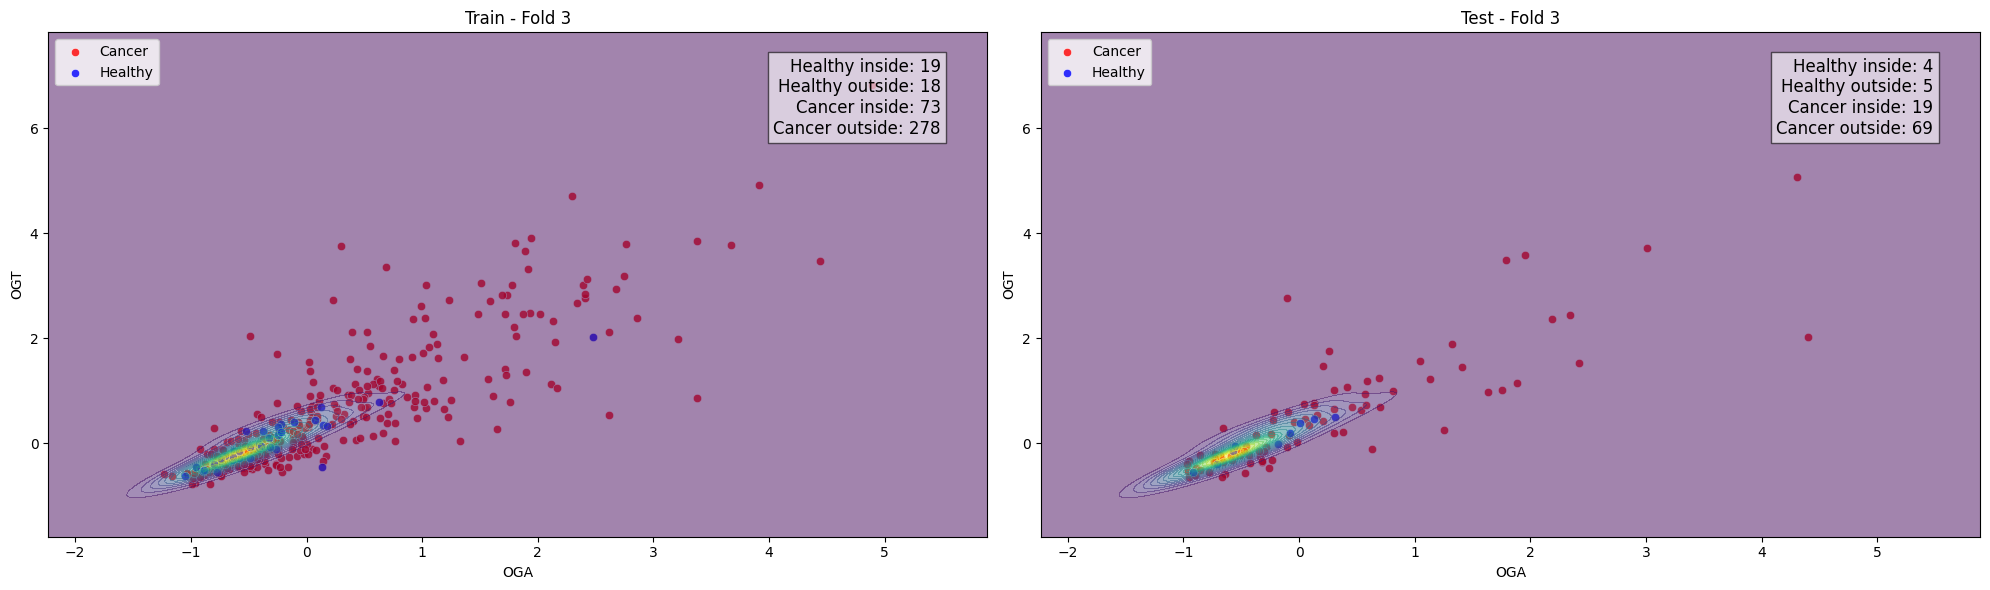

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


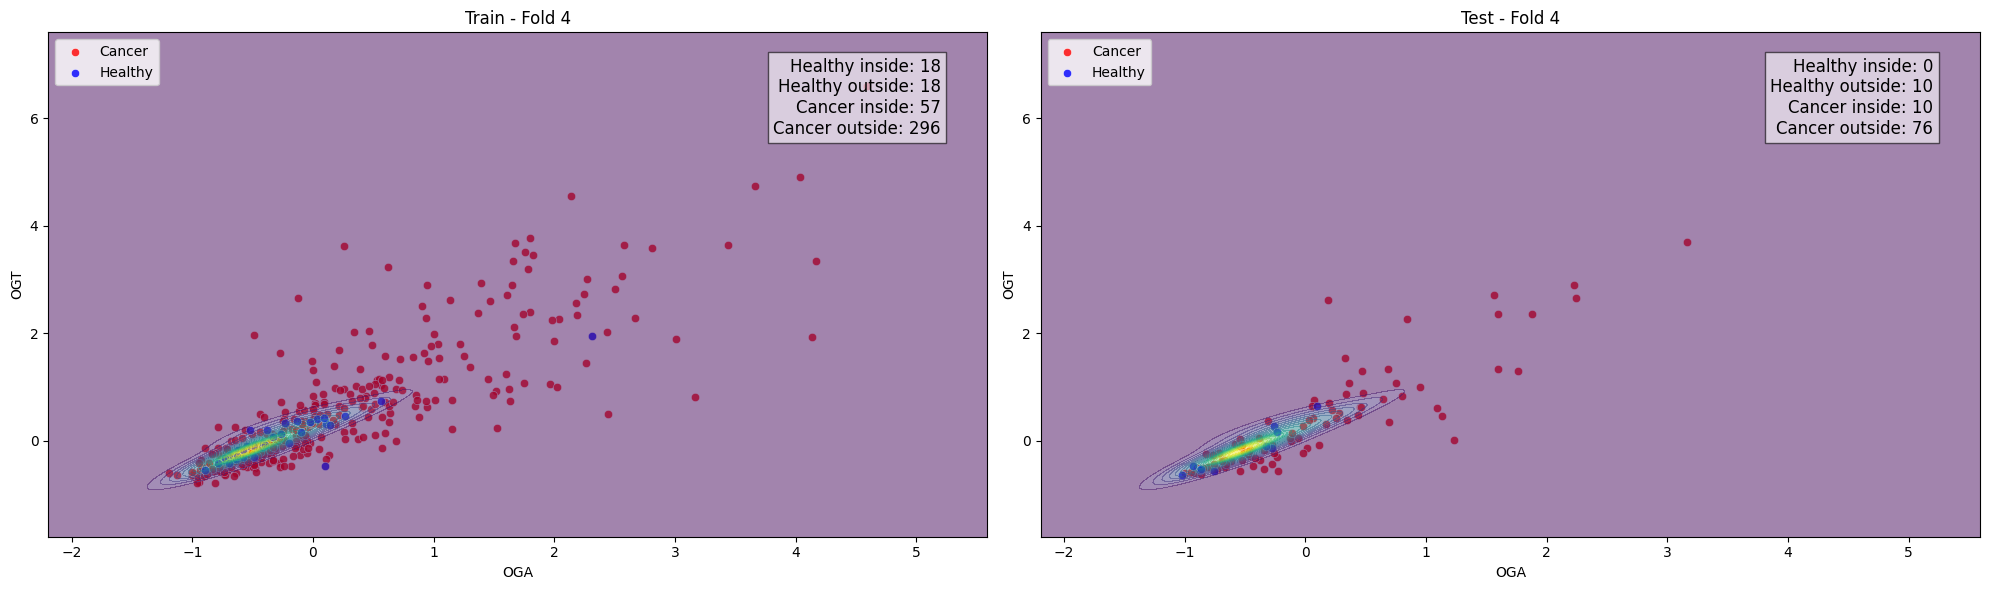

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:529: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_65489/4003542358.py:530: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


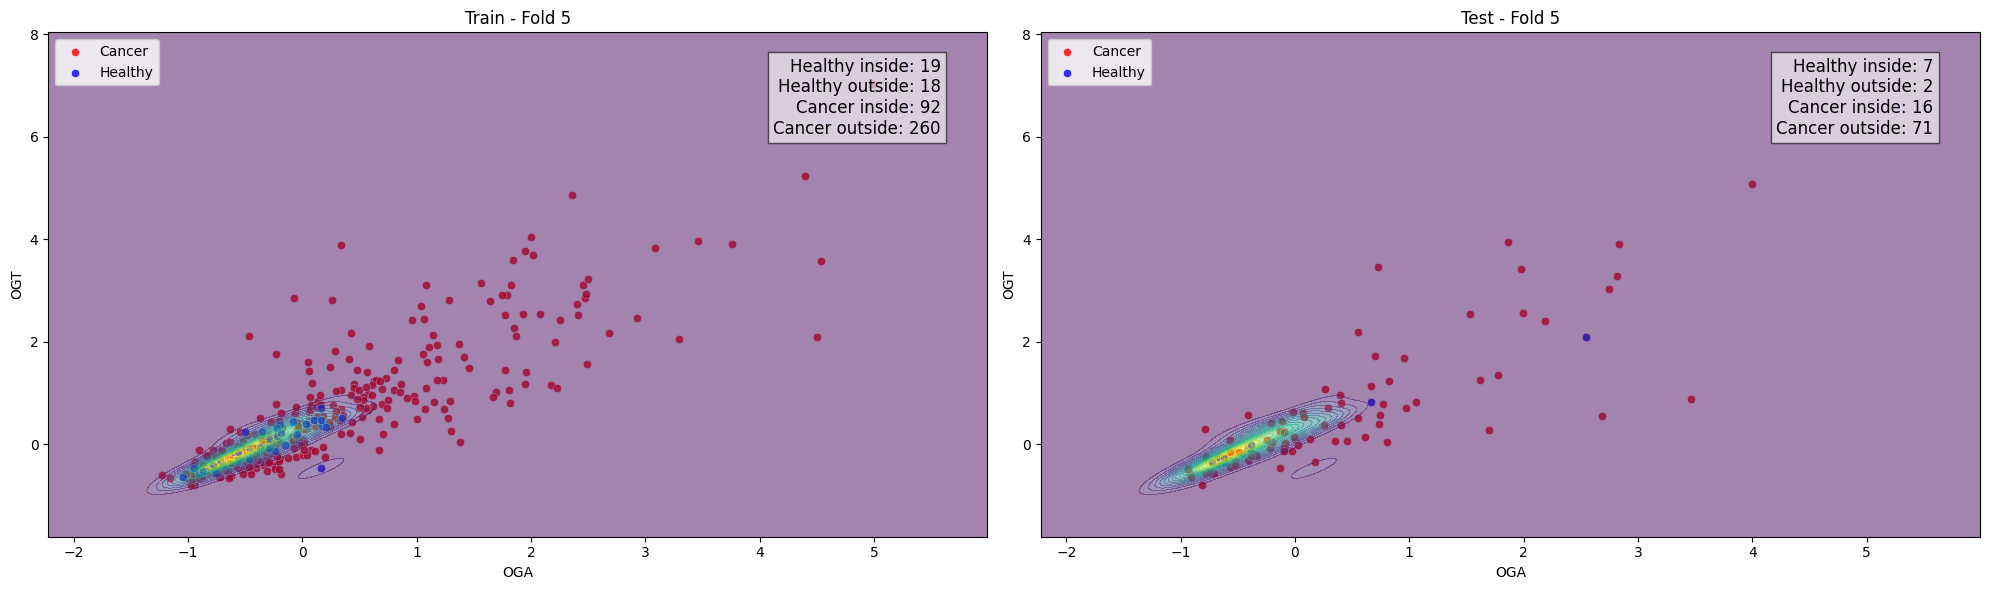

In [13]:
# Assign O-GlcNAcylation dysregulation values to each sample (from train set) and visualize the results
updated_results_utr = plot_and_assign_dysregulation(results_utr, column_name='cancer_stage', levels = 20)


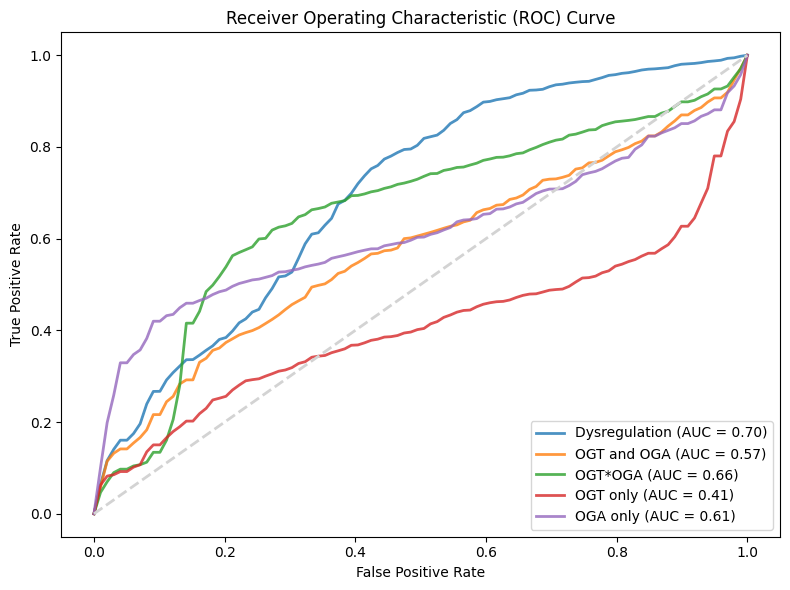

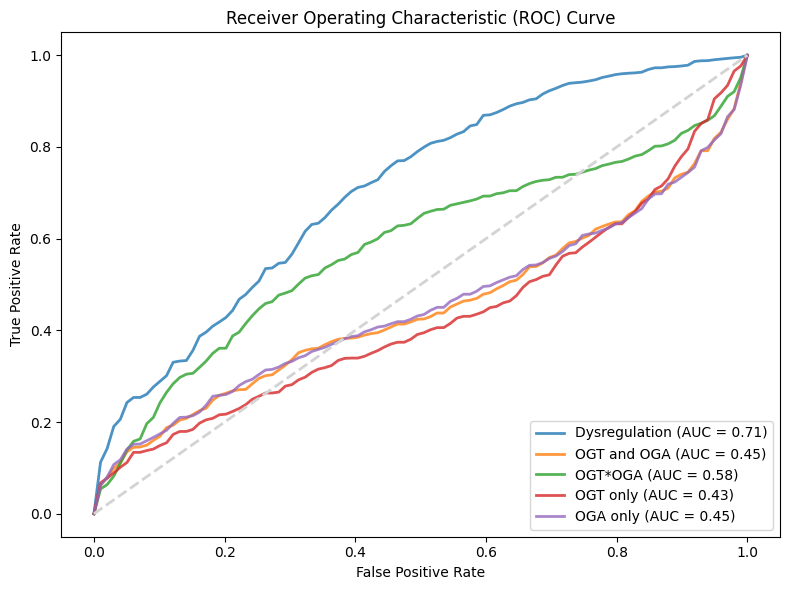

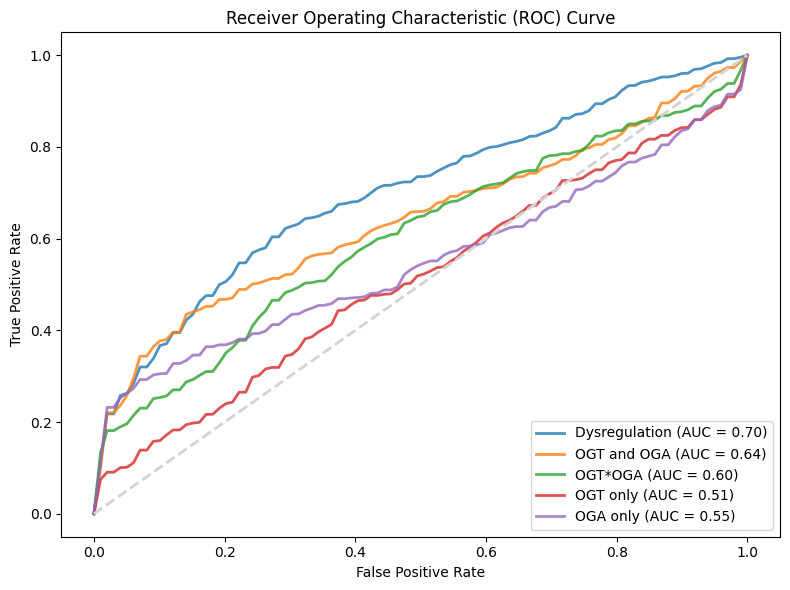

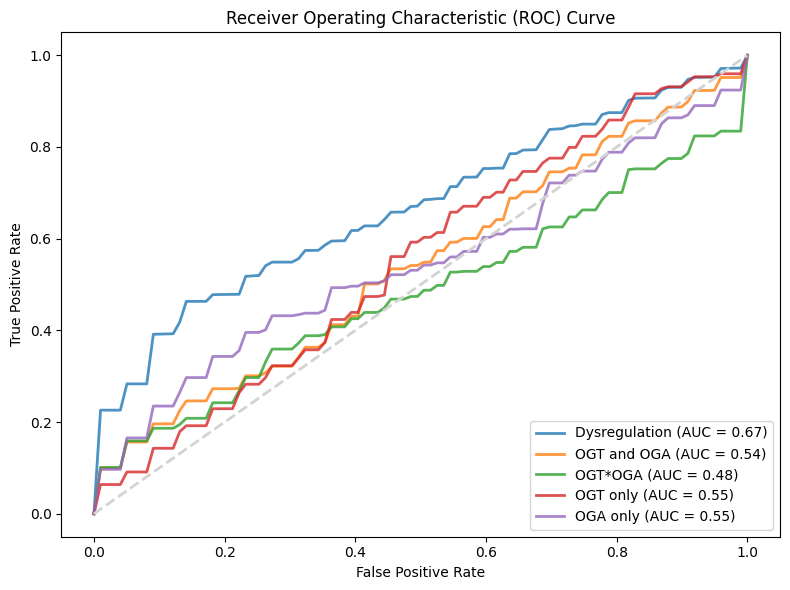

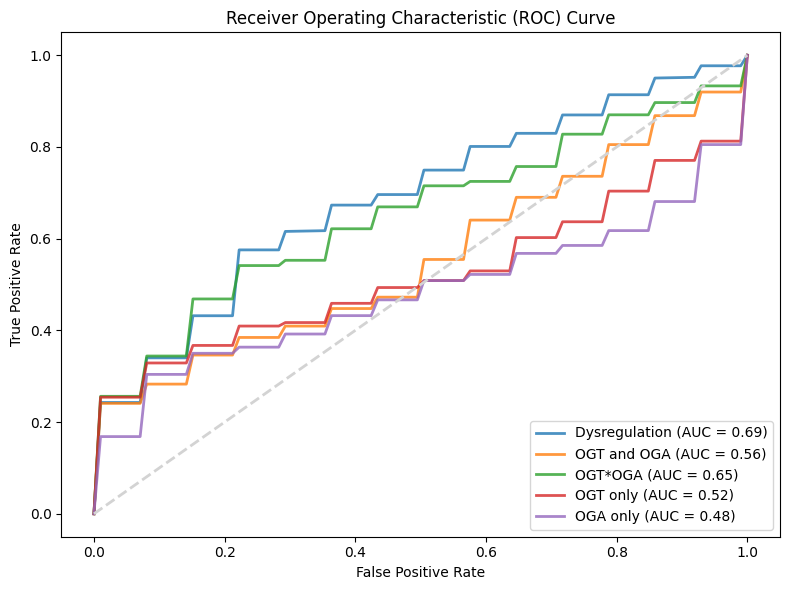

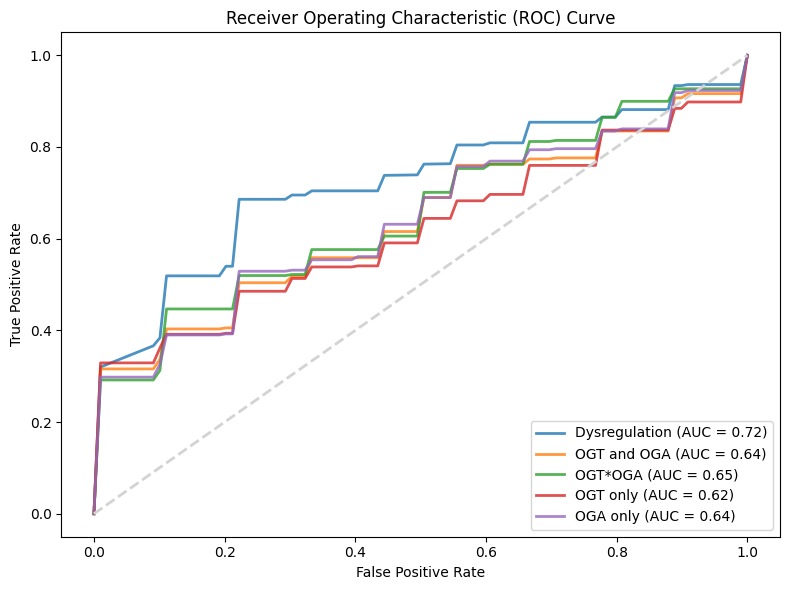

In [14]:
# Plot ROC curves for datasets
plot_roc_curves_comparison(updated_results_bmb, 'cancer_type')
plot_roc_curves_comparison(updated_results_lng, 'cancer_stage')
plot_roc_curves_comparison(updated_results_kid, 'cancer_stage')
plot_roc_curves_comparison(updated_results_brs, 'cancer_stage')
plot_roc_curves_comparison(updated_results_thy, 'cancer_stage')
plot_roc_curves_comparison(updated_results_utr, 'cancer_stage')